# <u> A. WebScraping Step </u>

# 1.Importing the Necessary Libraries

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import selenium
import time
import requests
import re
import pandas as pd
# import undetected_chromedriver as uc

# 2. Creating Instance of ChromeDriver and adjusting some Chrome Parameters

In [2]:
chrome_options = webdriver.ChromeOptions()
chrome_options.page_load_strategy = 'none'
chrome_options.add_argument("start-maximized")
chrome_options.add_argument('--disable-blink-features=AutomationControlled')
chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
chrome_options.add_experimental_option('useAutomationExtension', False)
chrome_options.add_argument(r"--user-data-dir=C:\Users\Dell\AppData\Local\Google\Chrome\User Data")

chrome_options.add_argument("--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36")

service = Service(r"C:\Users\Dell\OneDrive\Documents\AML 2203- Advanced Python AI and ML Tools\IMDB Project\chromedriver.exe")

# WbDvr = uc.Chrome(headless=False,use_subprocess=False)

WbDvr = webdriver.Chrome(service=service, options=chrome_options)

WbDvr.delete_all_cookies()

WbDvr.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")
WbDvr.execute_cdp_cmd('Network.setUserAgentOverride', {"userAgent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
                                                                     'AppleWebKit/537.36 (KHTML, like Gecko) '
                                                                     'Chrome/85.0.4183.102 Safari/537.36'})

WbDvr.get('https://www.imdb.com/search/title/?title_type=feature&release_date=2020-01-01,2023-10-15&user_rating=1.0,&num_votes=1,&languages=en&moviemeter=1,&runtime=1,&start=4651&ref_=adv_nxt')
WebDriverWait(WbDvr, 100).until(lambda WbDvr: WbDvr.execute_script('return document.readyState') == 'complete')

# 3. Creating 2 DataFrames for Scraping Movie Data and User Reviews Data

In [3]:
# DataFrame for storing IMDB Movie related data
df_1=pd.DataFrame(columns=["Movie Name","Total Votes","Movie Release Year","Certification Type","Movie Duration","Movie Genre","Overall IMDB Rating",
"Overall IMDB Ranking","Movie Plot","Directors List","Writers List","Actors List","Number of Critic Reviews",
"Number of User Reviews","IMDB Metascore","Total Oscar Nominations","Total Oscar Won","Total Wins","Total Nominations",
"Total Budget","Gross-US & Canada","Opening Weekend-US & Canada","Gross Worldwide"])
df_1

In [4]:
# DataFrame for storing User Reviews and Individual Ratings
df_3=pd.DataFrame(columns=["User_Ratings","User_Reviews"])
df_3

# 4. Performing Web Scraping Process

In [5]:
page_number=1

total_movie_count=WbDvr.find_element(By.XPATH,"//*[@id='main']/div/div[1]/div[2]/span[1]").text
total_movie_count=int(total_movie_count.split("of")[1].split("titles")[0].strip().replace(",",""))

while WbDvr.find_element(By.XPATH,"//*[@id='main']/div/div[1]/div[2]/span[1]").is_displayed()==True:
    
    total_movies_per_page=len(WbDvr.find_elements(By.CLASS_NAME,"lister-item-header"))
    
    for total_list in range(1,total_movies_per_page+1):
        
        movie_serial_number=WbDvr.find_elements(By.CSS_SELECTOR,"h3.lister-item-header span.lister-item-index.unbold.text-primary")
        movie_serial_number=movie_serial_number[total_list-1].text.replace(".","").replace(",","")
        movie_serial_number=int(movie_serial_number)
        
        print("Processing Movie Number-",movie_serial_number, "on page number-",page_number, "out of total movies-",total_movie_count)

        # Getting the name of the movie
        movie_details=WbDvr.find_elements(By.CSS_SELECTOR,f"h3.lister-item-header a")
        movie_details=movie_details[total_list-1]
        movie_link=movie_details.get_attribute("href")
        movie_name=movie_details.text.strip()
   
        # Getting the overall votes count received for the movie
        votes_count_text=WbDvr.find_elements(By.CLASS_NAME,f"sort-num_votes-visible")
        votes_count_text=votes_count_text[total_list-1].text
        votes_count_pattern = r'Votes:\s*([\d,]+)'
        votes_count_match = re.search(votes_count_pattern, votes_count_text)

        if votes_count_match:
            votes_count = votes_count_match.group(1).replace(',', '')
        else:
            votes_count=np.nan
        
        # Opening a new window to open each movie page in a different Chrome tab 
        WbDvr.execute_script("window.open('');")
        WbDvr.switch_to.window(WbDvr.window_handles[1])
        WbDvr.get(movie_link)
        
        WebDriverWait(WbDvr, 500).until(lambda WbDvr: WbDvr.execute_script('return document.readyState') == 'complete')
        
        # For getting the Year of release, Rating and Duration of the movie in minutes
        year_rating_duration_text=WbDvr.find_element(By.XPATH,"/html/body/div[2]/main/div/section[1]/section/div[3]/section/section/div[2]/div[1]/ul").text.strip()
        year_rating_duration_text=year_rating_duration_text.replace("\n"," ")

        year_pattern = r'(\d{4})'
        rating_pattern = r'(\b[a-zA-Z\s]+\b)'
        hours_pattern = r'(\d+h)'
        minutes_pattern = r'(\d+m)'

        year_match = re.search(year_pattern, year_rating_duration_text)
        rating_match = re.search(rating_pattern, year_rating_duration_text)
        hours_match = re.search(hours_pattern, year_rating_duration_text)
        minutes_match = re.search(minutes_pattern, year_rating_duration_text)

        if year_match:
            year_of_release=year_match.group(1)  
        else:
            year_of_release=np.nan

        if rating_match:
            rating=rating_match.group(1).strip()
        else:
            rating=np.nan

        if hours_match:
            movie_duration_hours=hours_match.group(1)
            movie_duration_hours=int(movie_duration_hours.split("h")[0])
            movie_duration_hours = movie_duration_hours * 60
        else:
            movie_duration_hours=np.nan

        if minutes_match:
            movie_duration_minutes=minutes_match.group(1)
            movie_duration_minutes=int(movie_duration_minutes.split("m")[0])
        else:
            movie_duration_minutes=np.nan

        total_movie_duration=movie_duration_hours + movie_duration_minutes
        
        # Getting the Genre of the movie
        movie_genre=WbDvr.find_element(By.XPATH,"/html/body/div[2]/main/div/section[1]/section/div[3]/section/section/div[3]/div/div[1]/section/div[1]").text.strip()
        movie_genre=movie_genre.replace("\n",",")
        
        # Getting the IMDB Rating and Popularity of the movie
        imdb_rating_ranking_text=WbDvr.find_element(By.XPATH,"/html/body/div[2]/main/div/section[1]/section/div[3]/section/section/div[2]/div[2]/div").text.strip()

        imdb_rating_pattern = r'IMDb RATING\n([\d.]+)'
        ranking_pattern = r'POPULARITY\n(\d+)'

        imdb_rating_match = re.search(imdb_rating_pattern, imdb_rating_ranking_text)
        ranking_match = re.search(ranking_pattern, imdb_rating_ranking_text)

        if imdb_rating_match:
            imdb_rating = float(imdb_rating_match.group(1)) 
        else:
            imdb_rating=np.nan

        if ranking_match:
            imdb_ranking = float(ranking_match.group(1)) 
        else:
            imdb_ranking=np.nan
        
        # Getting the plot of the movie
        movie_plot=WbDvr.find_element(By.XPATH,"/html/body/div[2]/main/div/section[1]/section/div[3]/section/section/div[3]/div/div[1]/section/p").text.strip()
        
        # Getting the list of director's associated with the movie
        director_list=[]

        count_of_directors=len(WbDvr.find_elements(By.XPATH,"/html/body/div[2]/main/div/section[1]/section/div[3]/section/section/div[3]/div/div[1]/section/div/div/ul/li[1]/div/ul/li"))

        for i in range(1,count_of_directors+1):
            inidividual_director=WbDvr.find_element(By.XPATH,"/html/body/div[2]/main/div/section[1]/section/div[3]/section/section/div[3]/div/div[1]/section/div/div/ul/li[1]/div/ul/li[" + str(i) + "]").text.strip()
            director_list.append(inidividual_director)
        
        director_list = ", ".join(director_list)
        
        # Getting the list of writer's associated with the movie
        writer_list=[]

        count_of_writers=len(WbDvr.find_elements(By.XPATH,"/html/body/div[2]/main/div/section[1]/section/div[3]/section/section/div[3]/div/div[1]/section/div/div/ul/li[2]/div/ul/li"))

        for i in range(1,count_of_writers+1):
            inidividual_writer=WbDvr.find_element(By.XPATH,"/html/body/div[2]/main/div/section[1]/section/div[3]/section/section/div[3]/div/div[1]/section/div/div/ul/li[2]/div/ul/li[" + str(i) + "]").text.strip()
            writer_list.append(inidividual_writer)
        
        writer_list=", ".join(writer_list)
        
        # Getting the list of actor's associated with the movie
        actor_list=[]
        count_of_actors=len(WbDvr.find_elements(By.XPATH,"/html/body/div[2]/main/div/section[1]/section/div[3]/section/section/div[3]/div/div[1]/section/div/div/ul/li[3]/div/ul/li"))
        for i in range(1,count_of_actors+1):
            inidividual_actor=WbDvr.find_element(By.XPATH,"/html/body/div[2]/main/div/section[1]/section/div[3]/section/section/div[3]/div/div[1]/section/div/div/ul/li[3]/div/ul/li[" + str(i) + "]").text.strip()
            actor_list.append(inidividual_actor)
        
        actor_list=", ".join(actor_list)
        
        # Getting the User Reviews, Critic Reviews and Metascore value 
        user_critic_reviews_metascore_text = WbDvr.find_elements(By.XPATH,"/html/body/div[2]/main/div/section[1]/section/div[3]/section/section/div[3]/div[2]/div[2]/ul")

        if user_critic_reviews_metascore_text:
            all_values = user_critic_reviews_metascore_text[0].text

            user_reviews_pattern = r'([\d]+)\nUser reviews\n'
            critic_reviews_pattern = r'([\d]+)\nCritic reviews\n'
            metascore_pattern = r'([\d]+)\nMetascore'

            user_reviews_match = re.search(user_reviews_pattern, all_values)
            critic_reviews_match = re.search(critic_reviews_pattern, all_values)
            metascore_match = re.search(metascore_pattern, all_values)

            if user_reviews_match:
                user_reviews = int(user_reviews_match.group(1))
            else:
                user_reviews=np.nan

            if critic_reviews_match:
                critic_reviews = int(critic_reviews_match.group(1))
            else:
                critic_reviews=np.nan

            if metascore_match:
                metascore = int(metascore_match.group(1))
            else:
                metascore=np.nan  
        else:
            user_reviews=np.nan
            critic_reviews=np.nan
            metascore=np.nan
        
        section_count=len(WbDvr.find_elements(By.XPATH,"/html/body/div[2]/main/div/section[1]/div/section/div/div[1]/section/div[1]"))
        df_2=pd.DataFrame()

        for x in range(1,section_count+1):
            section_text=WbDvr.find_element(By.XPATH,"/html/body/div[2]/main/div/section[1]/div/section/div/div[1]/section[" + str(x) + "]")
            section_text_value=section_text.get_attribute("cel_widget_id")
            
            # Getting the Awards,Nominations and Wins related values 
            if section_text_value == "StaticFeature_Awards":
                awards_list=WbDvr.find_element(By.XPATH,"/html/body/div[2]/main/div/section[1]/div/section/div/div[1]/section[" + str(x) + "]").text        

                nominated_oscar_pattern = r'Nominated for (\d+) Oscars'
                oscar_won_pattern = r'Won (\d+) Oscars'
                total_wins_pattern = r'(\d+) win'
                total_nominations_pattern = r'(\d+) nominations'

                nominated_oscar_match = re.search(nominated_oscar_pattern, awards_list)
                if nominated_oscar_match: 
                    total_nominated_oscar = int(nominated_oscar_match.group(1))
                else:
                    total_nominated_oscar=np.nan

                oscar_won_match = re.search(oscar_won_pattern, awards_list)
                if oscar_won_match: 
                    total_oscar_won = int(oscar_won_match.group(1))
                else:
                    total_oscar_won=np.nan

                total_wins_match = re.search(total_wins_pattern, awards_list)
                if total_wins_match: 
                    total_wins = int(total_wins_match.group(1))
                else:
                    total_wins=np.nan

                total_nominations_match = re.search(total_nominations_pattern, awards_list)
                if total_nominations_match: 
                    total_nominations = int(total_nominations_match.group(1))
                else:
                    total_nominations=np.nan
                
                df_1.loc[movie_serial_number,"Total Oscar Nominations"]=total_nominated_oscar
                df_1.loc[movie_serial_number,"Total Oscar Won"]=total_oscar_won
                df_1.loc[movie_serial_number,"Total Wins"]=total_wins
                df_1.loc[movie_serial_number,"Total Nominations"]=total_nominations
                    
            # Getting the User Reviews and Individual Votes related values 
            elif section_text_value == "StaticFeature_UserReviews":
                review_button_text=WbDvr.find_element(By.XPATH,"/html/body/div[2]/main/div/section[1]/div/section/div/div[1]/section[" + str(x) + "]/div[1]/div/div").text.strip()
                
                if review_button_text == 'Be the first to review':
                    pass
                else:
                    review_button_click=WbDvr.find_elements(By.XPATH,"//a[@class='ipc-title-link-wrapper']")
                    
                    for j in range(1,len(review_button_click)):
                        reviews_button_click=review_button_click[j-1].get_attribute("href")

                        if reviews_button_click.find("reviews")>0:
                            WbDvr.get(reviews_button_click)
                            break
                        else:
                            pass

                    WebDriverWait(WbDvr, 500).until(lambda WbDvr: WbDvr.execute_script('return document.readyState') == 'complete')
                    
                    time.sleep(2)
                    # Clicking on the Hide Spoilers Checbox
                    WbDvr.find_element(By.XPATH,"//span[@class='lister-widget-sprite lister-checkbox']").click()

                    WebDriverWait(WbDvr, 500).until(lambda WbDvr: WbDvr.execute_script('return document.readyState') == 'complete')

                    total_reviews_count=len(WbDvr.find_elements(By.XPATH,"/html/body/div[2]/div/div[2]/div[3]/div[1]/section/div[2]/div[2]/div/div[1]/div[1]/a"))

                    for review_text in range(1,total_reviews_count):
                        if review_text == 6:
                            break
                        else:
                            User_Review=WbDvr.find_elements(By.XPATH,"//span[contains(@class,'rating-other-user-rating')]")[review_text-1].text.strip()
                            User_Review=User_Review.split('/')[0]
                            User_Review=int(User_Review)

                            User_Review_Rating=WbDvr.find_elements(By.CSS_SELECTOR,"div.lister-item-content a.title")[review_text-1].text.strip()

                            df_2.loc[review_text,"User_Ratings"] = User_Review_Rating
                            df_2.loc[review_text,"User_Reviews"] = User_Review

                    df_3=pd.concat([df_2,df_3])
                    time.sleep(2)
                    WbDvr.get(movie_link)
                    
                    WebDriverWait(WbDvr, 500).until(lambda WbDvr: WbDvr.execute_script('return document.readyState') == 'complete')
                    
            # Getting the Budget and Gross Worldwide related values 
            elif section_text_value == "StaticFeature_BoxOffice":
                budget_values=WbDvr.find_element(By.CSS_SELECTOR,"div[data-testid='title-boxoffice-section']").text.strip()
                
                budget_pattern = r'Budget\n\$(.*?)(?=\s*\()'
                gross_us_canada_pattern = r'Gross US & Canada\n\$(.*?)\n'
                opening_weekend_pattern = r'Opening weekend US & Canada\n\$(.*?)\w{3}\s(\d{2}, \d{4})'
                gross_worldwide_pattern = r'Gross worldwide\n\$(.*?)\n'

                budget_match = re.search(budget_pattern, budget_values)
                gross_us_canada_match = re.search(gross_us_canada_pattern, budget_values)
                opening_weekend_match = re.search(opening_weekend_pattern, budget_values)
                gross_worldwide_match = re.search(gross_worldwide_pattern, budget_values)

                if budget_match:
                    budget_value = budget_match.group(1).replace(',', '')  
                else:
                    budget_value=np.nan

                if gross_us_canada_match:    
                    gross_us_canada_value = gross_us_canada_match.group(1).replace(',', '')
                else:
                    gross_us_canada_value=np.nan

                if opening_weekend_match:    
                    opening_weekend_us_canada_value = opening_weekend_match.group(1).replace(',', '')
                else:
                    opening_weekend_us_canada_value=np.nan

                if gross_worldwide_match:
                    gross_worldwide_value = gross_worldwide_match.group(1).replace(',', '')
                else:
                    gross_worldwide_value = np.nan
                
                df_1.loc[movie_serial_number,"Total Budget"]=budget_value
                df_1.loc[movie_serial_number,"Gross-US & Canada"]=gross_us_canada_value
                df_1.loc[movie_serial_number,"Opening Weekend-US & Canada"]=opening_weekend_us_canada_value
                df_1.loc[movie_serial_number,"Gross Worldwide"]=gross_worldwide_value
        
        WbDvr.close()
        WbDvr.switch_to.window(WbDvr.window_handles[0])
        
        df_1.loc[movie_serial_number,"Movie Name"]=movie_name
        df_1.loc[movie_serial_number,"Total Votes"]=votes_count
        df_1.loc[movie_serial_number,"Movie Release Year"]=year_of_release
        df_1.loc[movie_serial_number,"Certification Type"]=rating
        df_1.loc[movie_serial_number,"Movie Duration"]=total_movie_duration
        df_1.loc[movie_serial_number,"Movie Genre"]=movie_genre
        df_1.loc[movie_serial_number,"Overall IMDB Rating"]=imdb_rating
        df_1.loc[movie_serial_number,"Overall IMDB Ranking"]=imdb_ranking
        df_1.loc[movie_serial_number,"Movie Plot"]=movie_plot
        df_1.loc[movie_serial_number,"Directors List"]=director_list
        df_1.loc[movie_serial_number,"Writers List"]=writer_list
        df_1.loc[movie_serial_number,"Actors List"]=actor_list
        df_1.loc[movie_serial_number,"Number of Critic Reviews"]=critic_reviews
        df_1.loc[movie_serial_number,"Number of User Reviews"]=user_reviews
        df_1.loc[movie_serial_number,"IMDB Metascore"]=metascore
        
    button_check = "div[class='nav'] a[class='lister-page-next next-page']"
    button_click_values = WbDvr.find_elements(By.CSS_SELECTOR, button_check)

    if len(button_click_values) == 1:
        next_button_check = button_click_values[0]
        next_button_check.click()
        WebDriverWait(WbDvr, 100).until(lambda WbDvr: WbDvr.execute_script('return document.readyState') == 'complete')
    elif len(button_click_values) == 2:
        next_button_check = button_click_values[1]
        next_button_check.click()
        WebDriverWait(WbDvr, 100).until(lambda WbDvr: WbDvr.execute_script('return document.readyState') == 'complete')
    else:
        print("List of movies is finished")
        break
        
    # For incrementing the counter of Page Number
    page_number = page_number + 1
    df_3=df_3.reset_index(drop=True)

# 5. Storing the Scraped Data into individual Data Frames

In [6]:
# # Final Dataset for storing the Movie Data
# df_1.to_excel("Final_Movie_Data.xlsx",index=False)

In [7]:
# # Final Dataset for storing the User Review Data
# df_3.to_excel("Final_User_Data.xlsx",index=False)

# <u> B. Data Analysis and Model Building Steps </u>

# 1.Importing the Necessary Libraries

In [8]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift

# 2. Reading the dataset

In [9]:
df=pd.read_excel("Final_Movie_Data.xlsx")

In [10]:
# Looking up the top 5 rows of the dataset
df.head(5)

Movie Name  Total Votes  Movie Release Year  \
0  Killers of the Flower Moon        61151                2023   
1                       Saw X        42235                2023   
2               Pain Hustlers         9876                2023   
3                    Saltburn          842                2023   
4      The Exorcist: Believer        22299                2023   

  Certification Type  Movie Duration              Movie Genre  \
0                  R           206.0      Crime,Drama,History   
1                  R           118.0  Horror,Mystery,Thriller   
2                  R           122.0              Crime,Drama   
3                  R           127.0    Comedy,Drama,Thriller   
4                  R           111.0                   Horror   

   Overall IMDB Rating  Overall IMDB Ranking  \
0                  8.1                   2.0   
1                  6.7                   5.0   
2                  6.5                   6.0   
3                  7.1                   7.0   
4                  4.9                   8.0   

                                          Movie Plot      Directors List  ...  \
0  When oil is discovered in 1920s Oklahoma under...     Martin Scorsese  ...   
1  A sick and desperate John travels to Mexico fo...      Kevin Greutert  ...   
2  Liza dreams of a better life for herself and h...         David Yates  ...   
3  A student at Oxford University finds himself d...     Emerald Fennell  ...   
4  When two girls disappear into the woods and re...  David Gordon Green  ...   

  Number of User Reviews IMDB Metascore  Total Oscar Nominations  \
0                  505.0           89.0                      NaN   
1                  357.0           60.0                      NaN   
2                   58.0           44.0                      NaN   
3                    8.0           62.0                      NaN   
4                  420.0           39.0                      NaN   

   Total Oscar Won  Total Wins  Total Nominations  Total Budget  \
0              NaN         NaN                3.0   200000000.0   
1              NaN         NaN                NaN    13000000.0   
2              NaN         NaN                NaN    50000000.0   
3              NaN         1.0                NaN           NaN   
4              NaN         NaN                NaN           NaN   

   Gross-US & Canada  Opening Weekend-US & Canada  Gross Worldwide  
0         42035063.0                   23253655.0       86035063.0  
1         50609863.0                          NaN       83550385.0  
2                NaN                          NaN              NaN  
3                NaN                          NaN              NaN  
4         59866575.0                          NaN      120982575.0  

[5 rows x 23 columns]

# 3. Describing Different Statistics of Dataset

In [11]:
# Identifying descriptive statistics measures of the dataset
df.describe()

Total Votes  Movie Release Year  Movie Duration  Overall IMDB Rating  \
count    4655.000000         4655.000000     4535.000000          4655.000000   
mean    12508.530612         2021.628357       99.020287             5.642707   
std     46272.764351            1.073277       17.351335             1.451923   
min         5.000000         2020.000000       61.000000             1.000000   
25%       171.000000         2021.000000       88.000000             4.700000   
50%       798.000000         2022.000000       96.000000             5.700000   
75%      4426.500000         2023.000000      106.000000             6.600000   
max    839419.000000         2023.000000      369.000000            10.000000   

       Overall IMDB Ranking  Number of Critic Reviews  Number of User Reviews  \
count            871.000000               1599.000000             3571.000000   
mean             120.135476                 92.066291               89.539625   
std              240.226957                 89.573971              158.749255   
min                1.000000                  2.000000                2.000000   
25%                2.000000                 32.000000                9.000000   
50%                3.000000                 61.000000               26.000000   
75%               80.000000                117.000000               84.000000   
max              985.000000                761.000000              996.000000   

       IMDB Metascore  Total Oscar Nominations  Total Oscar Won   Total Wins  \
count     1604.000000                22.000000        11.000000  1671.000000   
mean        57.763092                 3.818182         3.000000     7.439856   
std         15.167231                 2.061815         1.788854    18.923067   
min          7.000000                 2.000000         2.000000     1.000000   
25%         47.000000                 2.250000         2.000000     1.000000   
50%         58.000000                 3.000000         2.000000     3.000000   
75%         69.000000                 4.000000         3.000000     6.000000   
max         97.000000                 9.000000         7.000000   390.000000   

       Total Nominations  Total Budget  Gross-US & Canada  \
count        1436.000000  7.770000e+02       8.170000e+02   
mean           15.494429  3.008952e+07       2.420550e+07   
std            34.790292  5.491280e+07       7.400814e+07   
min             2.000000  2.700000e+01       1.800000e+02   
25%             3.000000  3.000000e+05       7.641700e+04   
50%             5.000000  4.500000e+06       8.031890e+05   
75%            12.000000  3.400000e+07       1.301369e+07   
max           362.000000  3.500000e+08       8.141151e+08   

       Opening Weekend-US & Canada  Gross Worldwide  
count                 5.570000e+02     1.772000e+03  
mean                  7.735797e+06     2.924730e+07  
std                   2.294756e+07     1.319935e+08  
min                   4.500000e+01     1.800000e+01  
25%                   2.648500e+04     5.143925e+04  
50%                   2.508110e+05     3.911350e+05  
75%                   4.700450e+06     4.343158e+06  
max                   2.601386e+08     2.320250e+09

In [12]:
# Identifying the number of rows and columns of the dataset
df.shape

(4655, 23)

In [13]:
# Identifying the data types of each column
df.dtypes

Movie Name                      object
Total Votes                      int64
Movie Release Year               int64
Certification Type              object
Movie Duration                 float64
Movie Genre                     object
Overall IMDB Rating            float64
Overall IMDB Ranking           float64
Movie Plot                      object
Directors List                  object
Writers List                    object
Actors List                     object
Number of Critic Reviews       float64
Number of User Reviews         float64
IMDB Metascore                 float64
Total Oscar Nominations        float64
Total Oscar Won                float64
Total Wins                     float64
Total Nominations              float64
Total Budget                   float64
Gross-US & Canada              float64
Opening Weekend-US & Canada    float64
Gross Worldwide                float64
dtype: object

# 4. Exploratory Data Analysis & Data Visualization

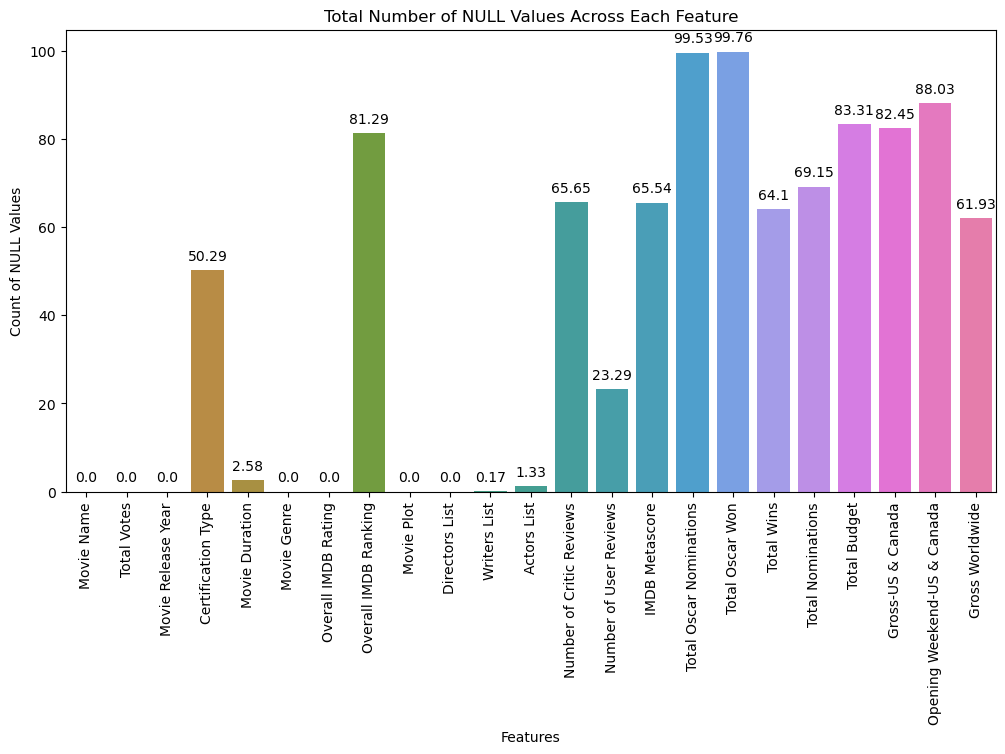

In [14]:
# Visualizing NULL values in the dataset across all the features
na_values_count = round(df.isna().sum()*100/len(df),2)

plt.figure(figsize=(12, 6))
ax=sns.barplot(x=na_values_count.index, y=na_values_count.values, palette='husl')
plt.title('Total Number of NULL Values Across Each Feature')
plt.xlabel('Features')
plt.ylabel('Count of NULL Values')
plt.xticks(rotation=90)
for counter in ax.patches:
    ax.annotate(f'{counter.get_height()}',
                (counter.get_x() + counter.get_width() / 2., counter.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                rotation='horizontal')
plt.show()

**From this visualization the following points can be inferred : -**
 
1. Total Oscar Won and Total Oscar Nominations are the features in the dataset where we have more than 99% of the data where NULL values are present hence we can consider dropping these columns while handling missing values.
    
2. For Overall IMDB Rating, Total Votes, Movie Release Year features we have 0% of missing values in the dataset hence these features can be used for model implementation.
    
3. There are features like Number of User Reviews, Certification Type, Movie Duration where there are less number of missing values as compared to the rest of the features hence we can consider imputing missing values for such columns.

In [15]:
# Separating numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

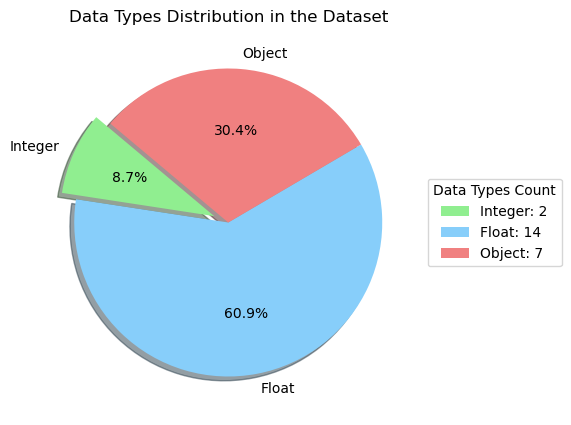

In [16]:
# Count the types
num_types = len(numerical_features)
float_types = len(df.select_dtypes(include=['float64']).columns)
int_types = num_types - float_types
object_types = len(categorical_features)

# Create a pie chart
labels = ['Integer', 'Float', 'Object']
sizes = [int_types, float_types, object_types]
colors = ['lightgreen', 'lightskyblue', 'lightcoral']
explode = (0.1, 0, 0)  # explode the 1st slice (Integer)

fig, ax = plt.subplots(figsize=(5, 5))
patches, texts, autotexts = ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                                   shadow=True, startangle=140)

# Add count information as legend
legend_labels = [f'{label}: {size}' for label, size in zip(labels, sizes)]
ax.legend(patches, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), title='Data Types Count')

plt.title('Data Types Distribution in the Dataset')
plt.show()


####  From this visualization the following point can be inferred : -

The pie chart illustrates the distribution of data types in the dataset, with a breakdown showing the percentage of integer, float, and object types. The legend provides counts for each data type, enhancing the visual representation of the dataset's composition.

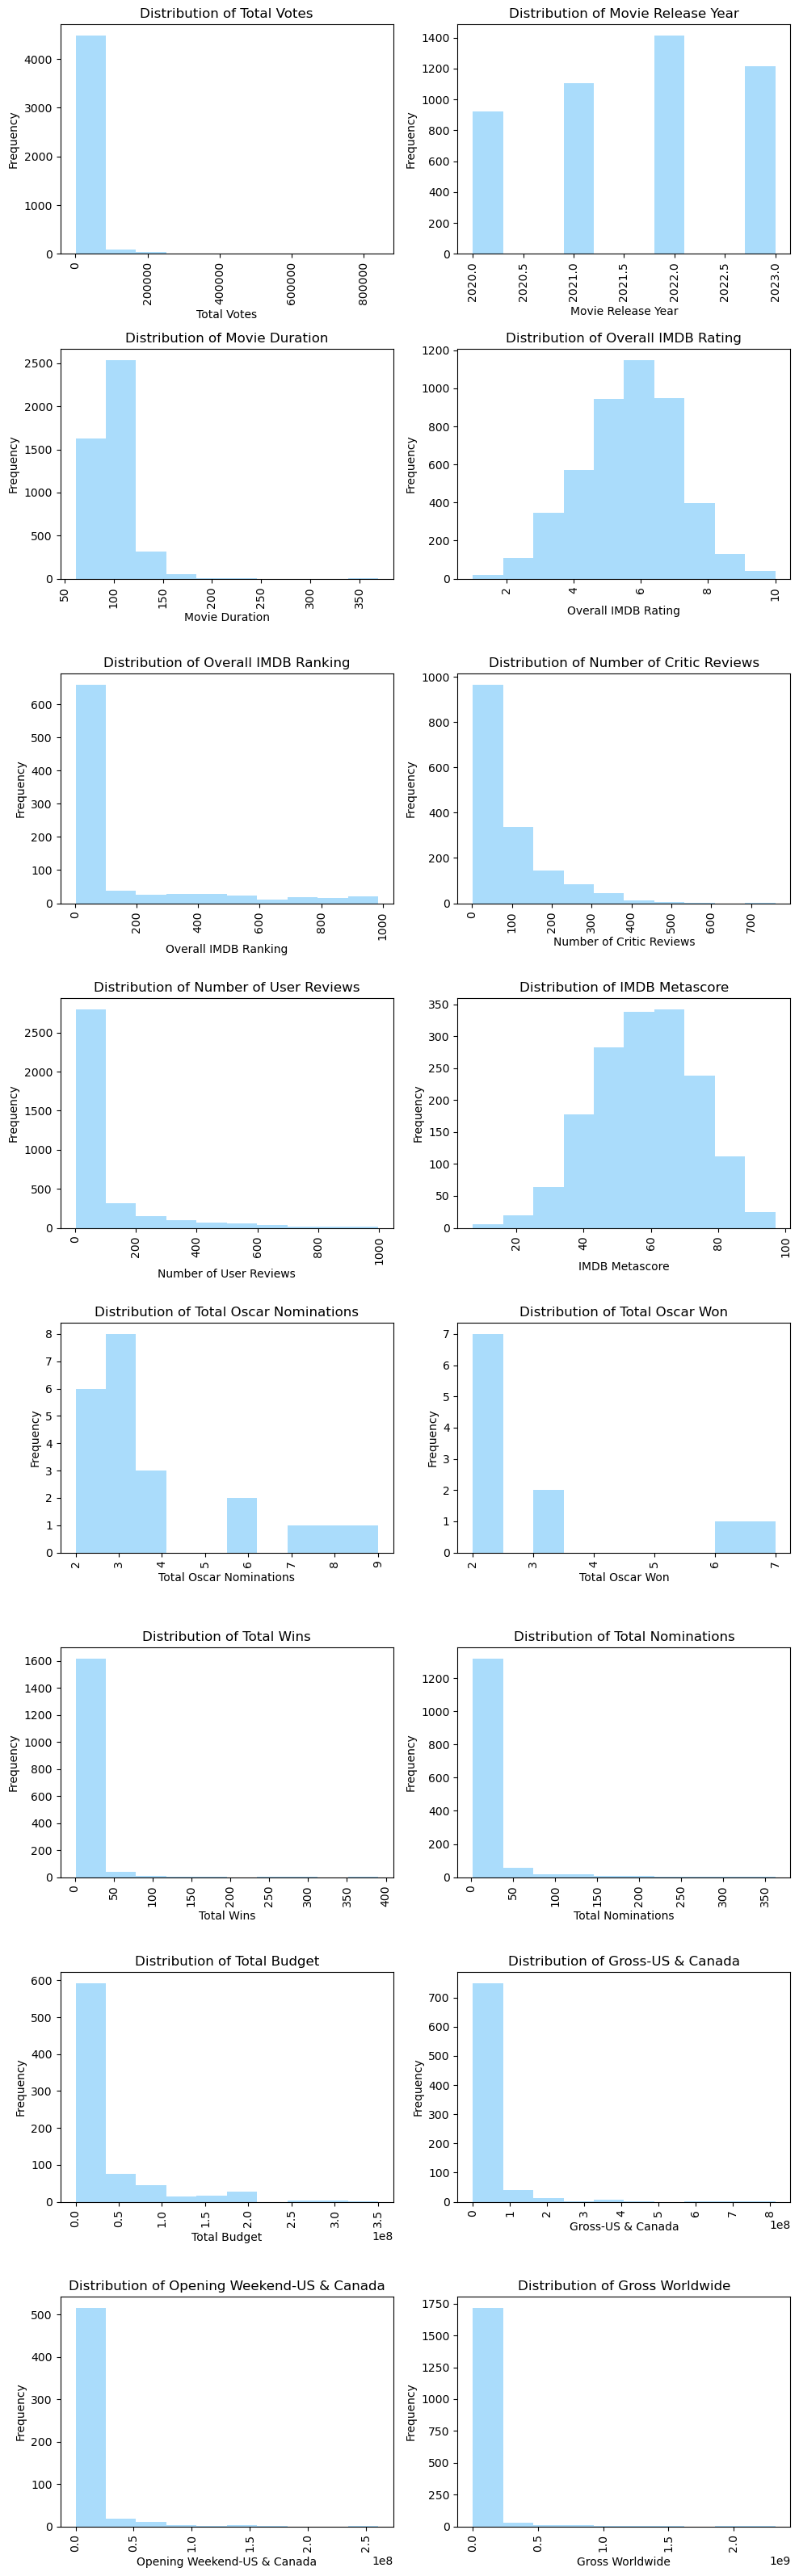

In [17]:
# Plotting histograms for numerical features
num_rows=8
num_cols=2
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5* num_cols, 4* num_rows))
axs = axs.flatten()
for i, j in enumerate(numerical_features):
    axs[i].hist(df[j], bins=10, color='lightskyblue', alpha=0.7)
    axs[i].set_title(f'Distribution of {j}')
    axs[i].set_xlabel(j)
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

**From this visualization the following points can be inferred : -**
1. In our dataset we have majority of the movies(~1400) which are released in the year 2022 and for the year 2023 we have a total movie count of ~1200. 
2. The IMDB Metascore is averaged at 60 which means that from our datsase the average IMDB Metascore of a movie is 60. 
3. For majority of the movies (~2500) the average movie duration is 100 mins in total.

#### KDE plots provide a smooth estimate of the distribution.

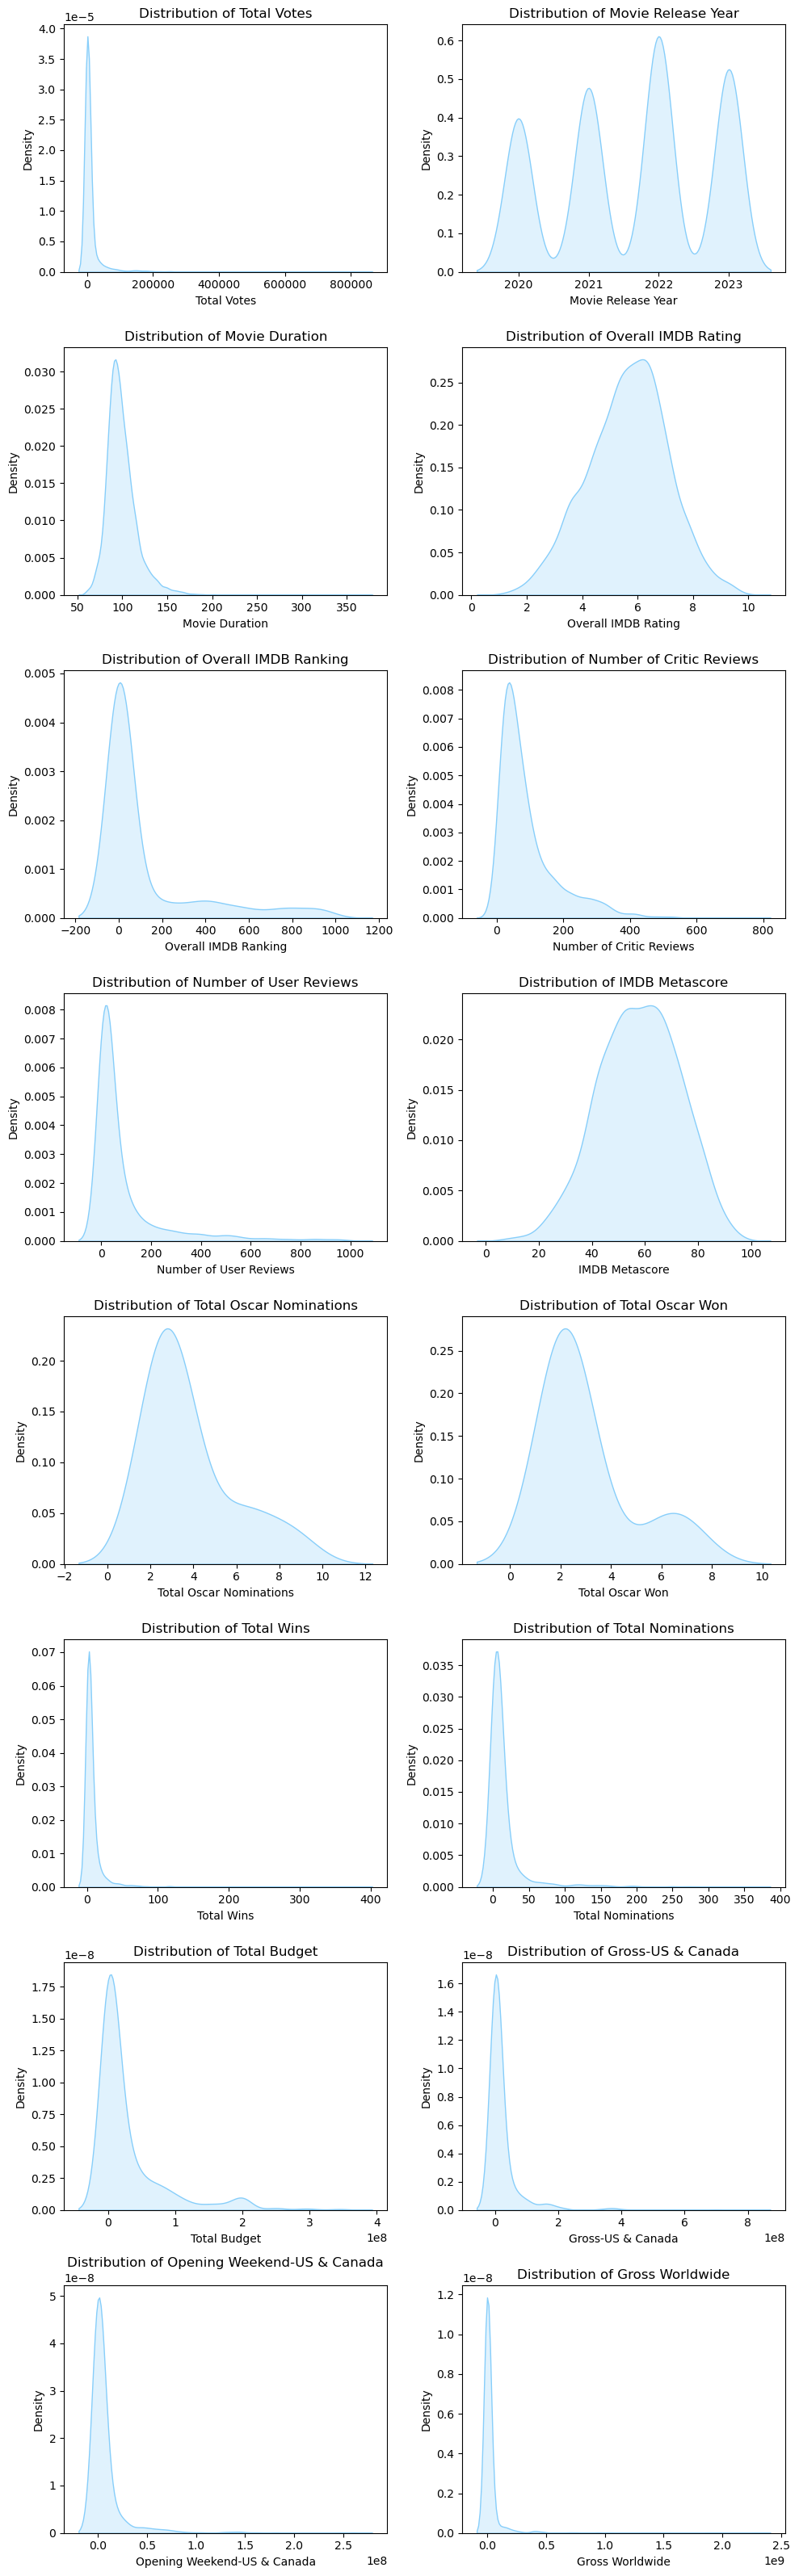

In [18]:
# Plotting Kernel Density Estimate (KDE) for Numerical Features

num_rows = 8
num_cols = 2
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 4 * num_rows))
axs = axs.flatten()
for i, j in enumerate(numerical_features):
    sns.kdeplot(df[j], color='lightskyblue', fill=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {j}')
    axs[i].set_xlabel(j)
    axs[i].set_ylabel('Density')
plt.tight_layout()
plt.show()


#### Boxplots provide a summary of the distribution, showing the median, quartiles, and potential outliers.

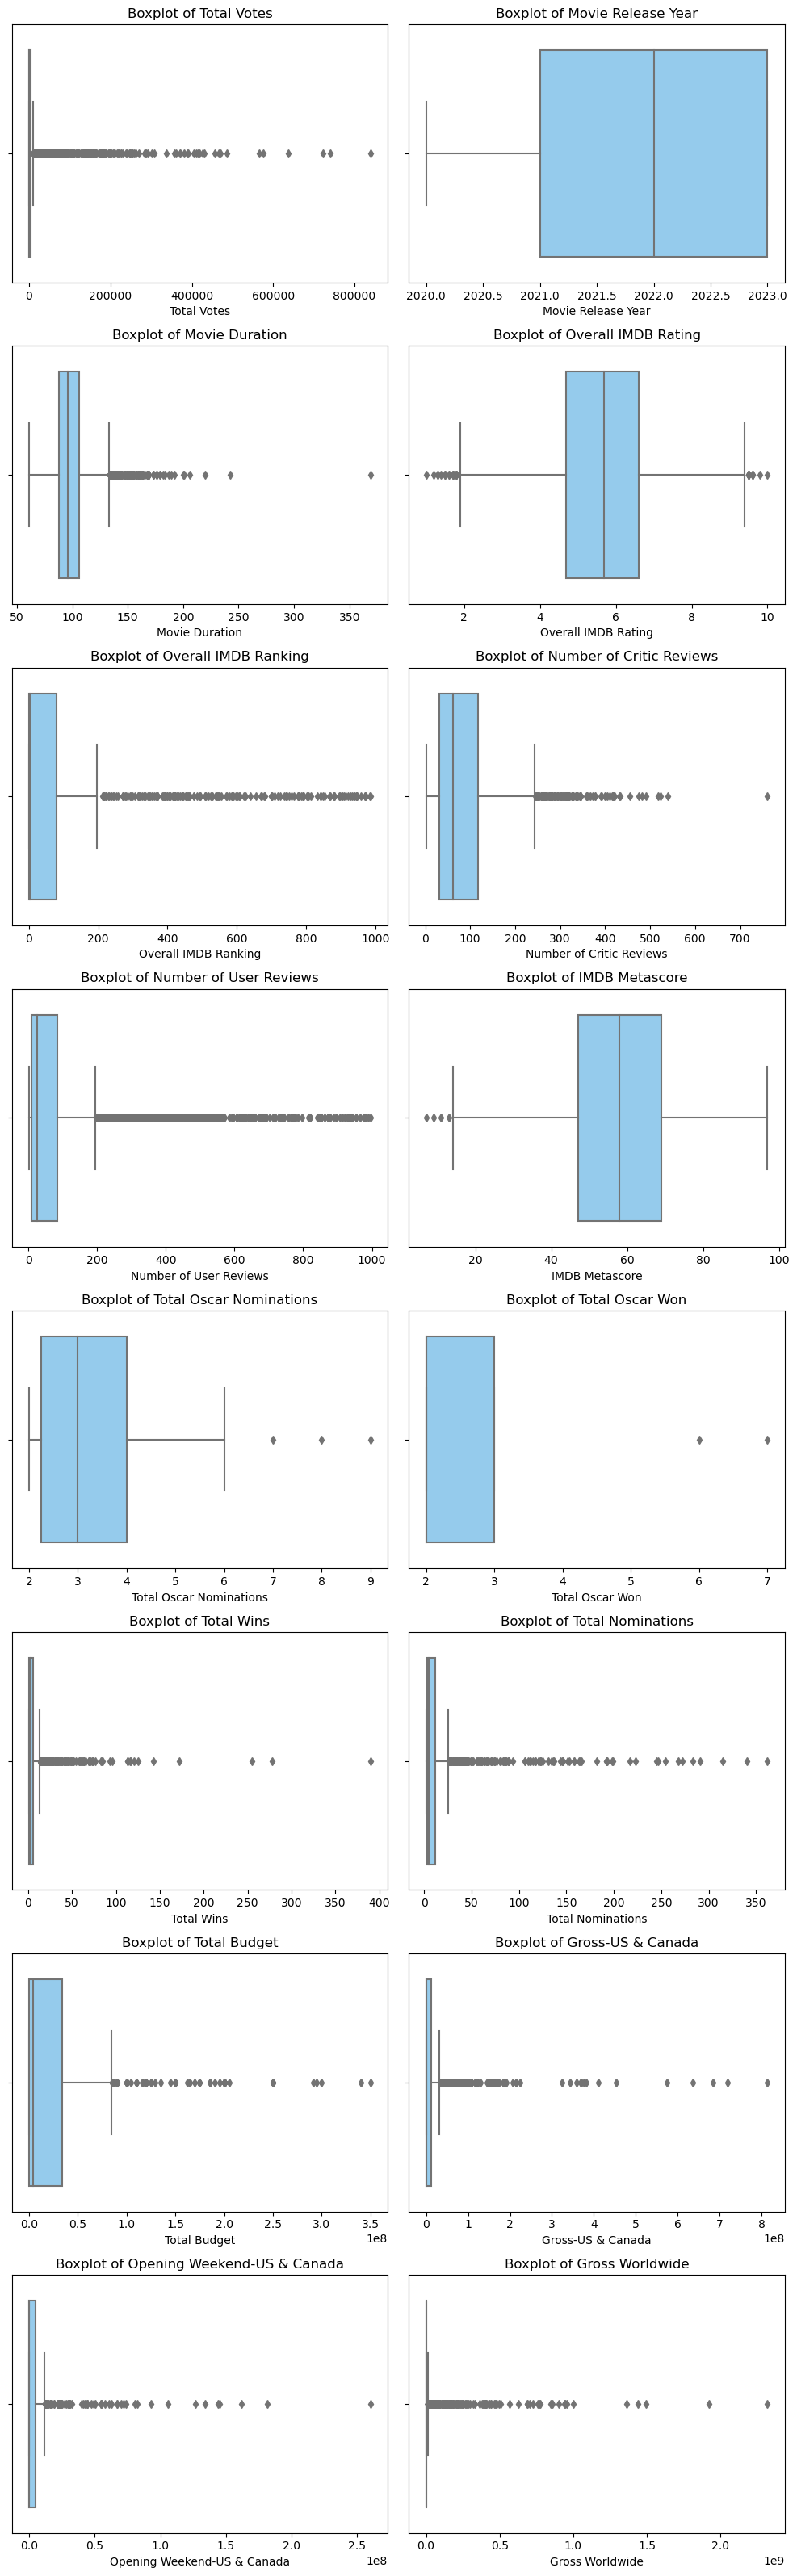

In [19]:
# Plotting Box plots for numerical features

num_rows = 8
num_cols = 2
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 4 * num_rows))
axs = axs.flatten()
for i, j in enumerate(numerical_features):
    sns.boxplot(x=df[j], color='lightskyblue', ax=axs[i])
    axs[i].set_title(f'Boxplot of {j}')
    axs[i].set_xlabel(j)
plt.tight_layout()
plt.show()


#### Violin plots combine aspects of box plots and kernel density plots.

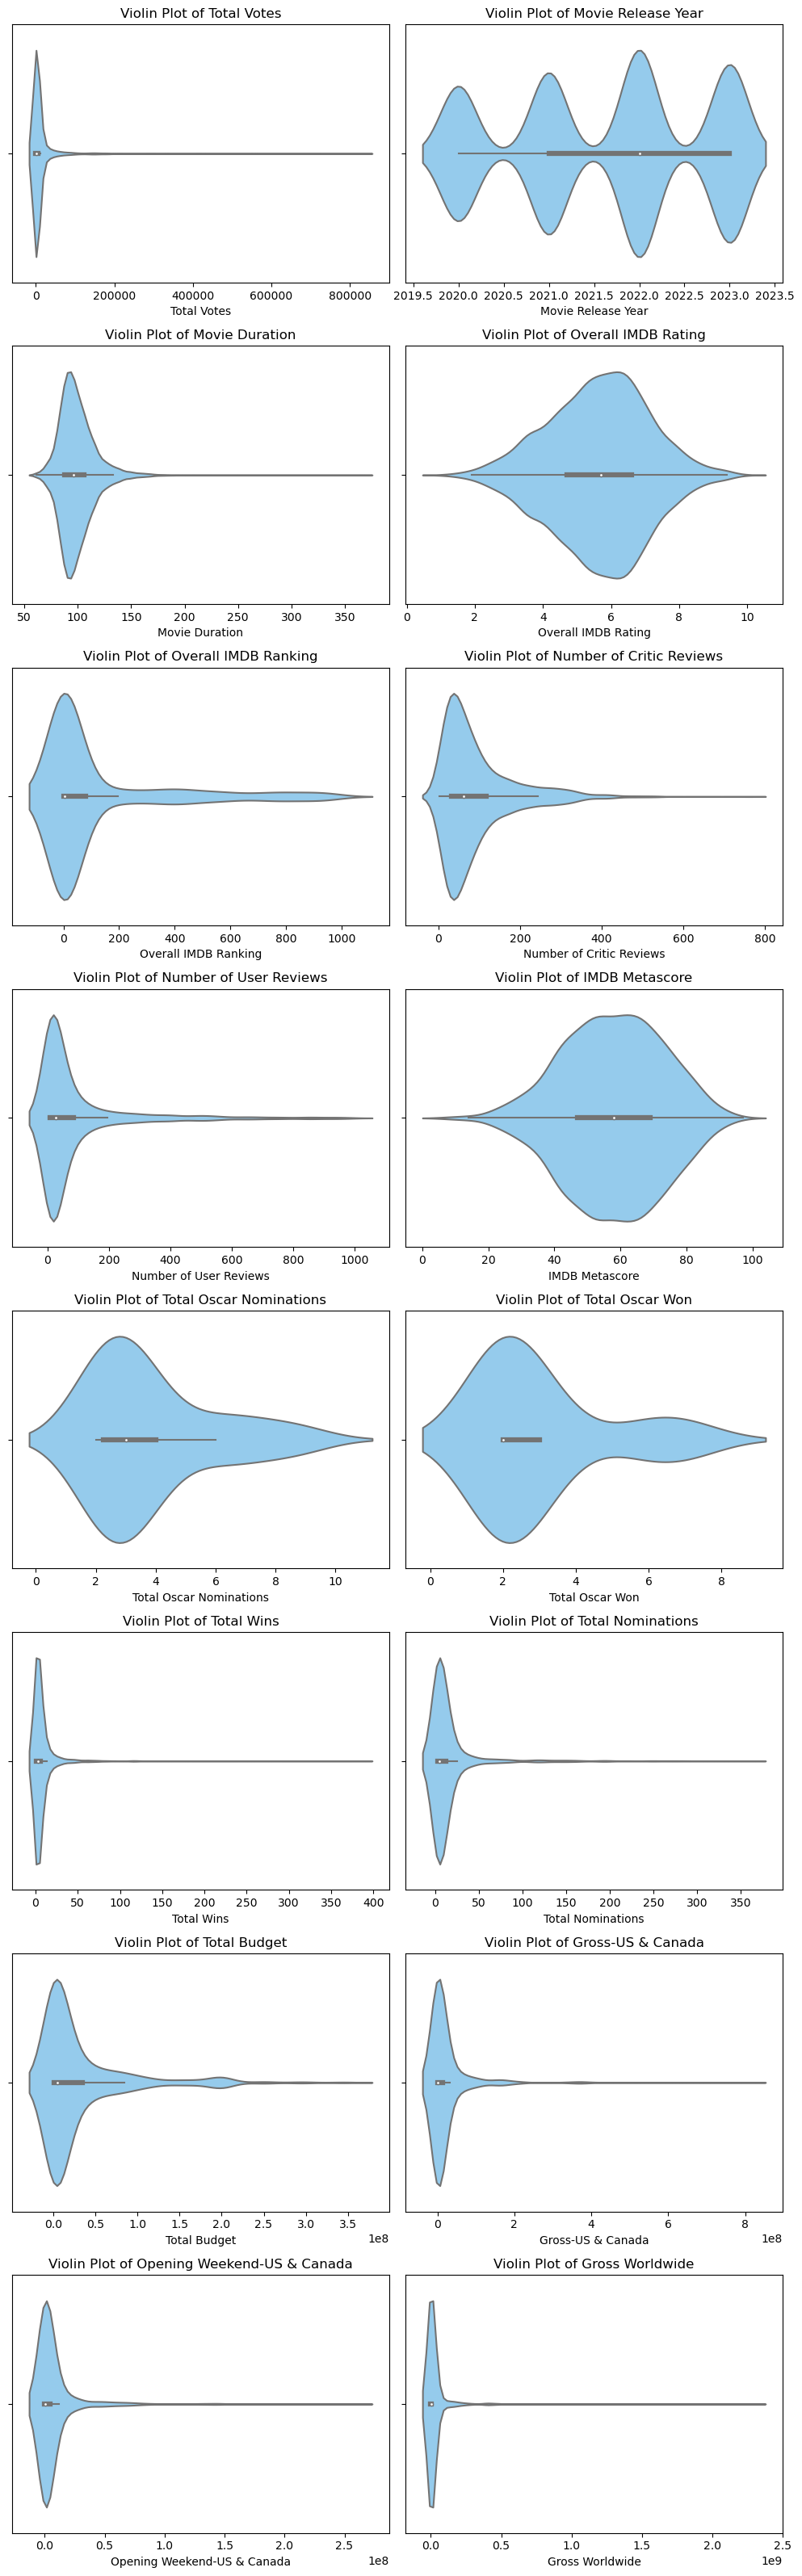

In [20]:
# Plotting voilin plots for numerical features
num_rows = 8
num_cols = 2
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 4 * num_rows))
axs = axs.flatten()
for i, j in enumerate(numerical_features):
    sns.violinplot(x=df[j], color='lightskyblue', ax=axs[i])
    axs[i].set_title(f'Violin Plot of {j}')
    axs[i].set_xlabel(j)
plt.tight_layout()
plt.show()


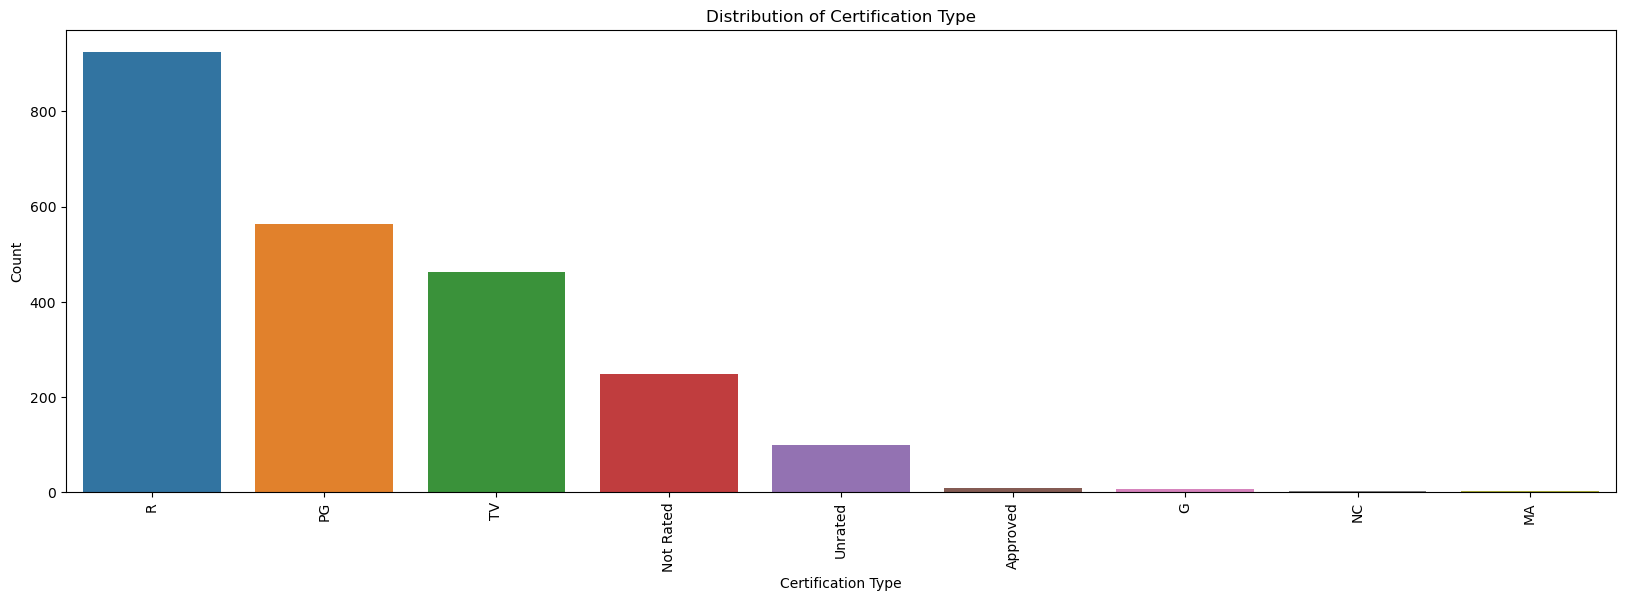

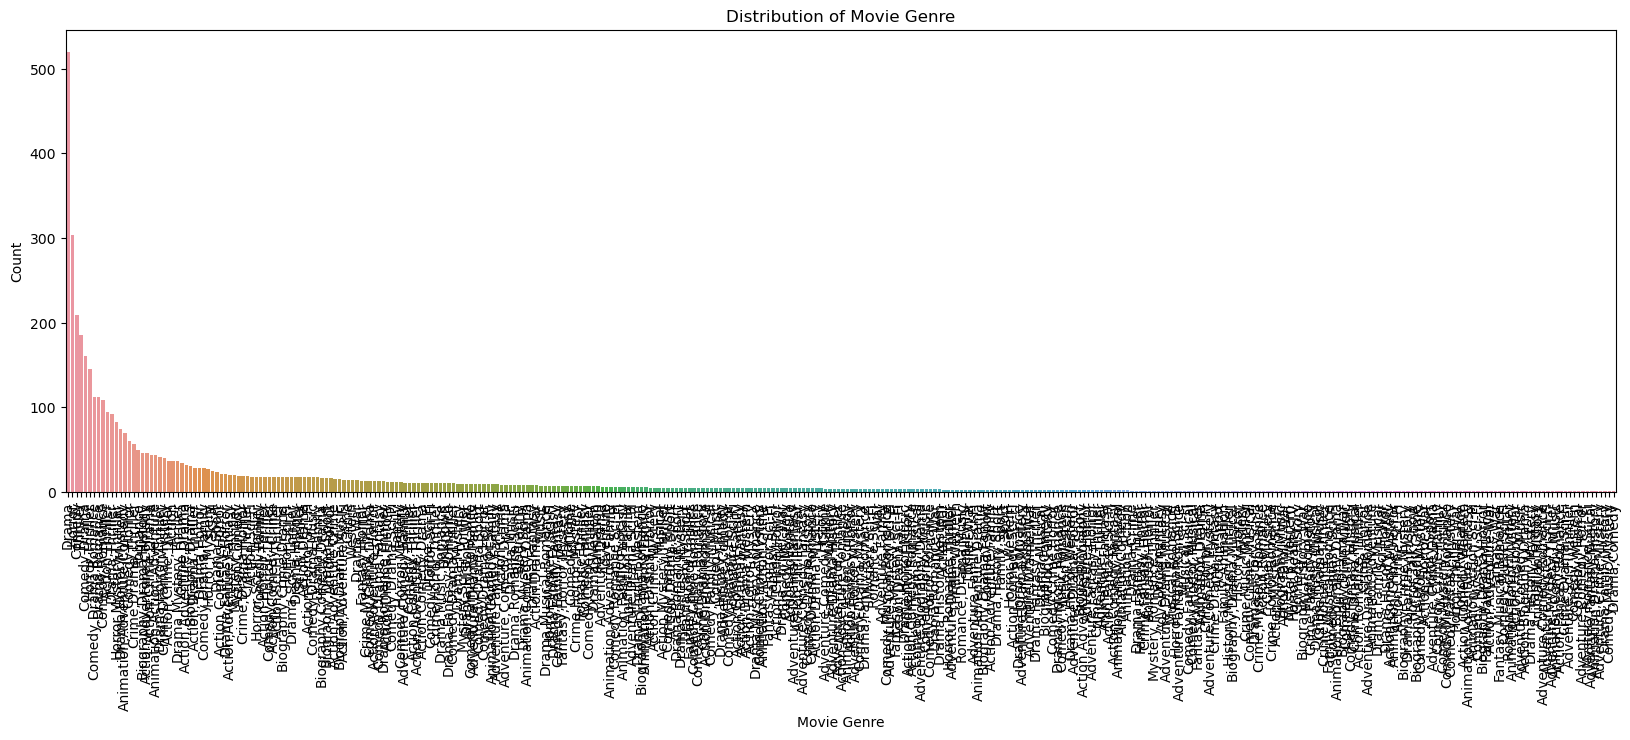

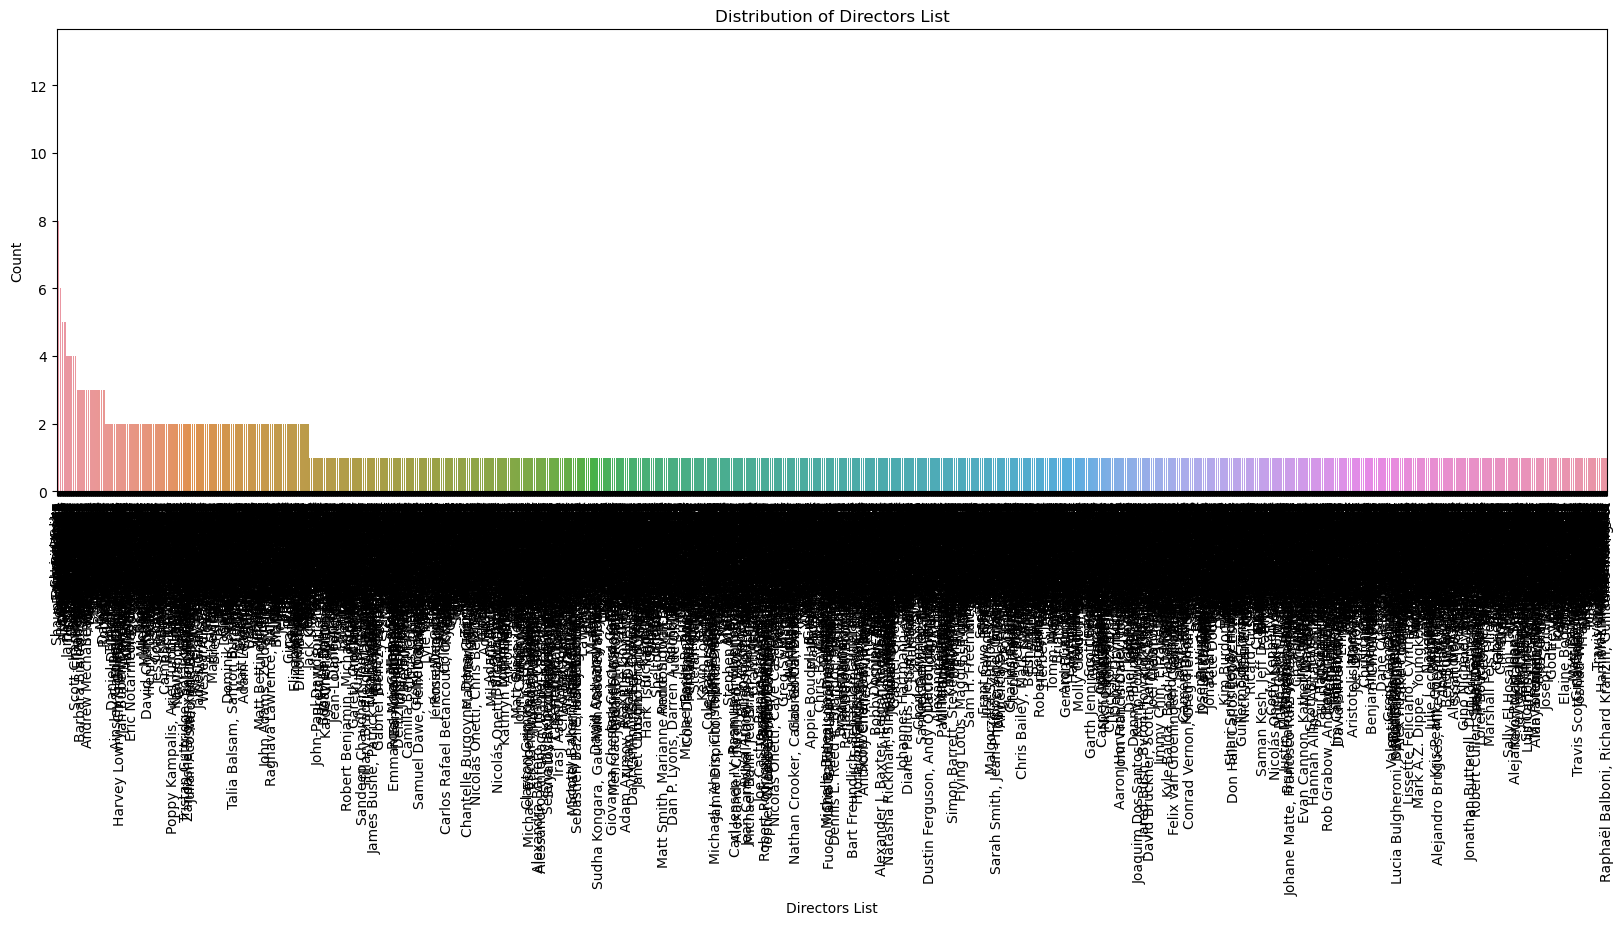

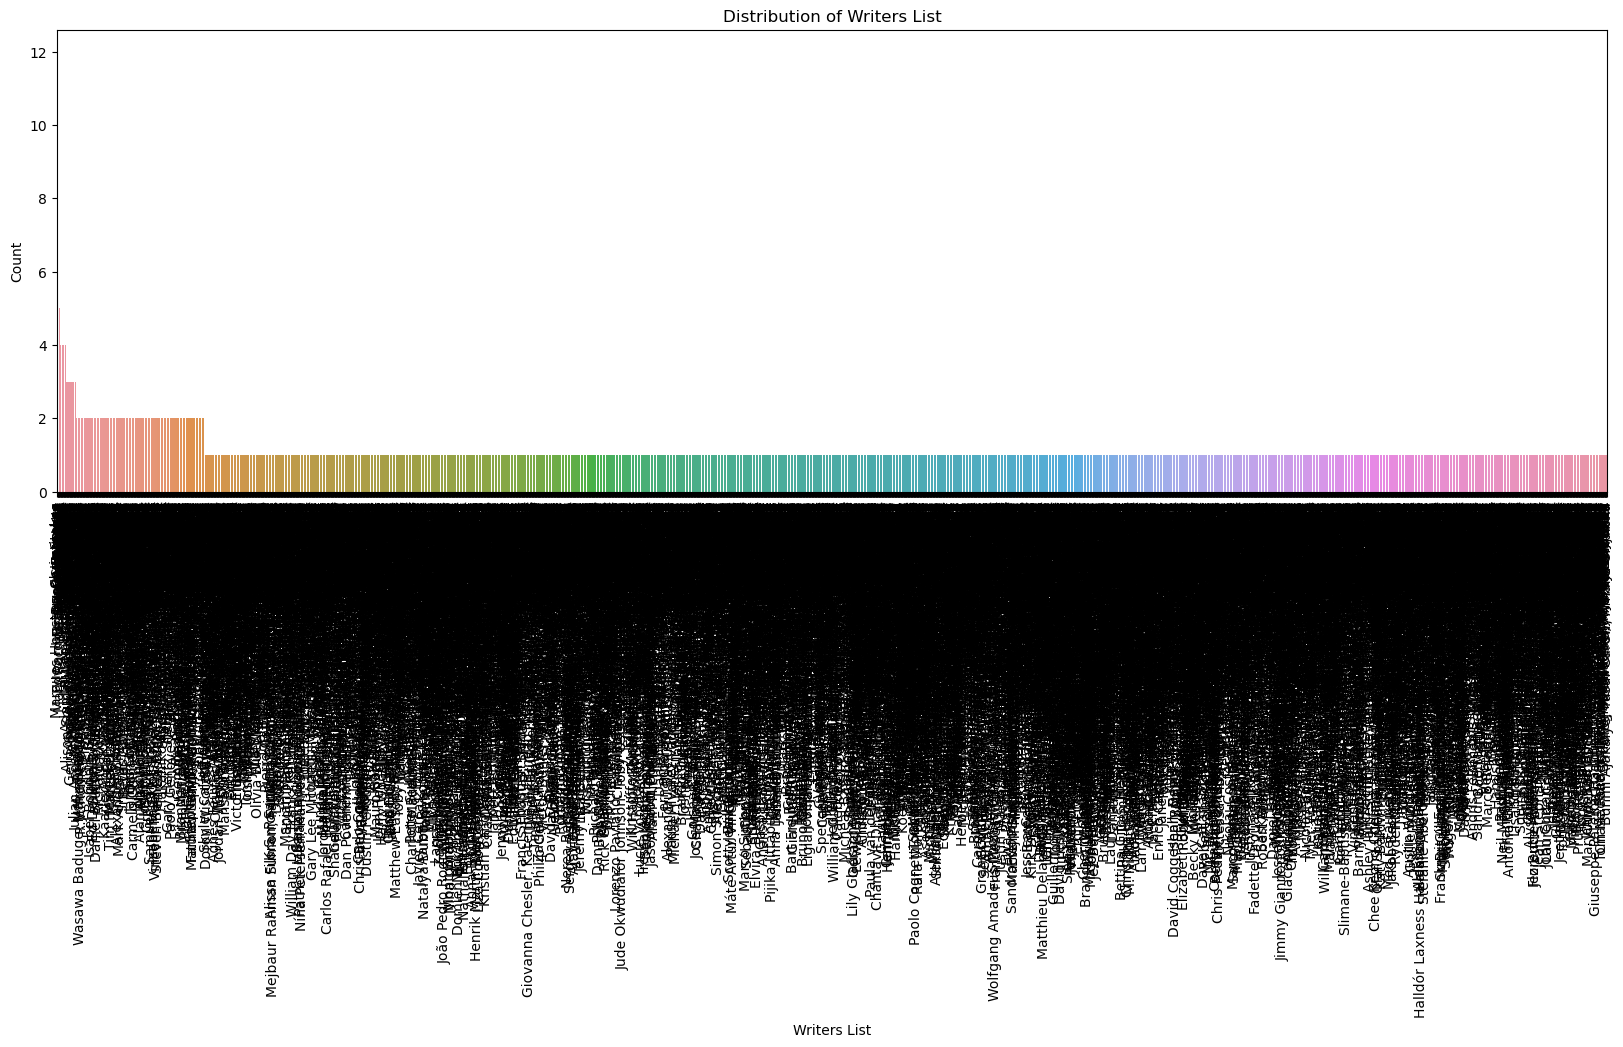

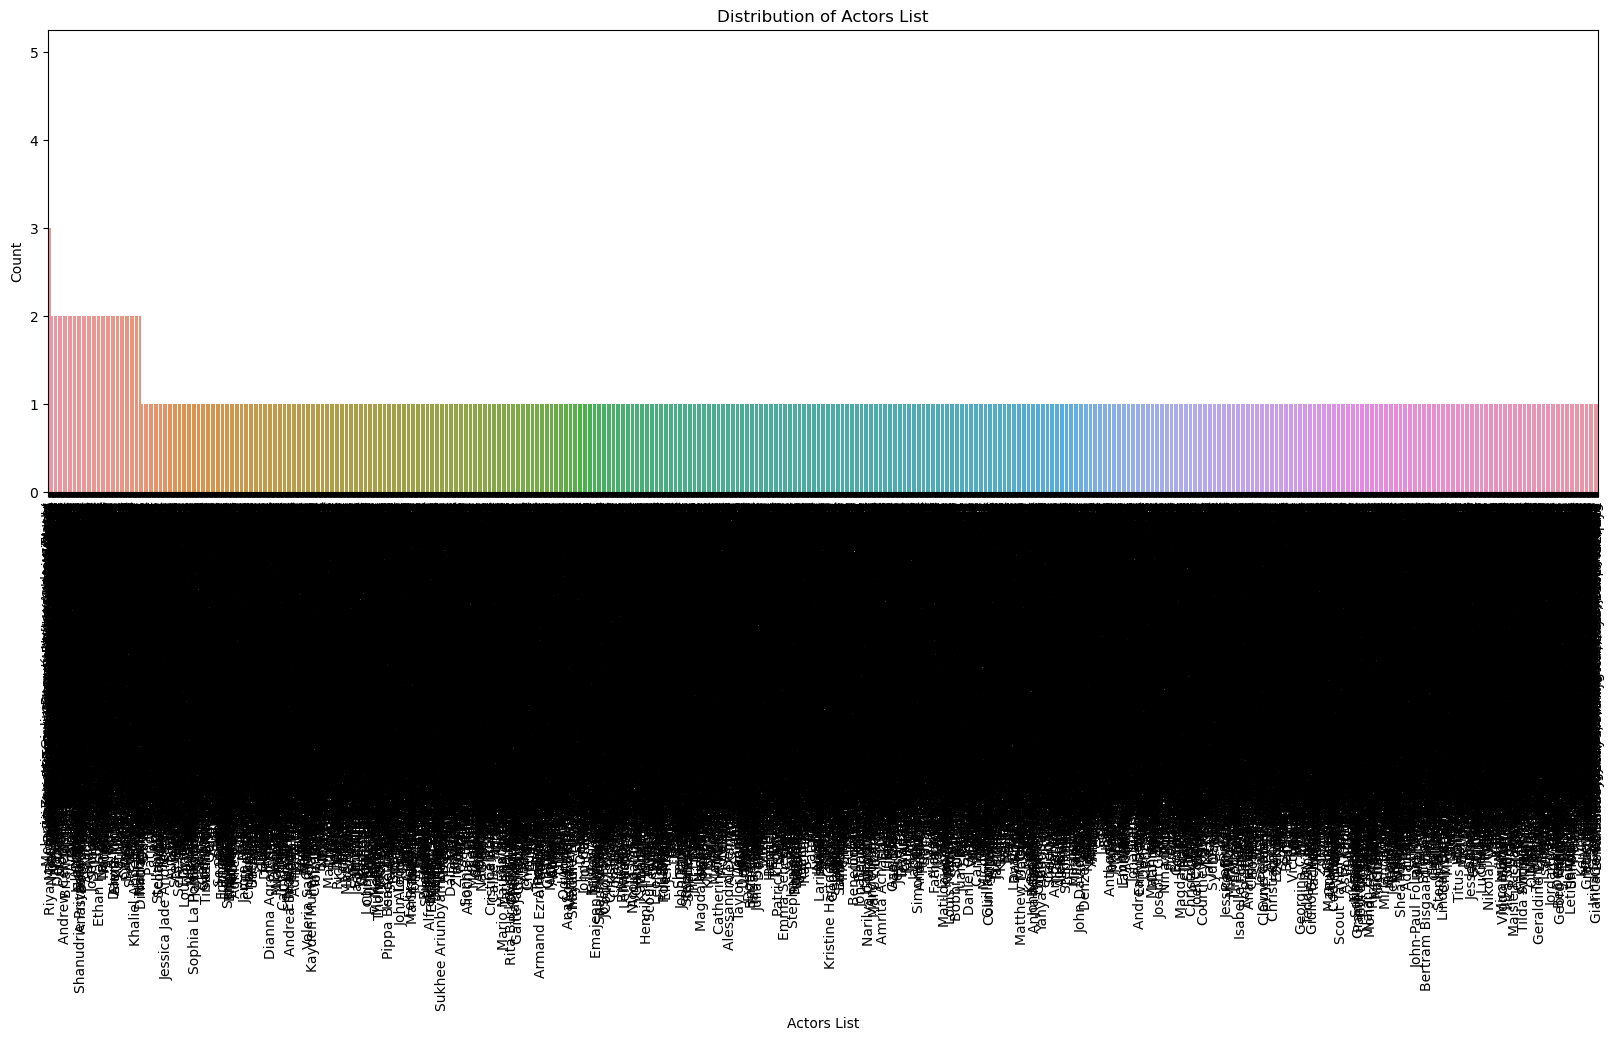

In [21]:
# Plotting barplots for categorical features except movie name and plot since these are not catgeorical features  
categorical_features.remove('Movie Name')
categorical_features.remove('Movie Plot')
for column in categorical_features:
    plt.figure(figsize=(20, 6))
    sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=90)
    plt.xlabel(column)
    plt.ylabel('Count')
plt.show()

**Since there are a lot of variables amongst the Categorical Features, we would be taking help of different 
visualizations which would consist of a cleaned dataset.**   

In [22]:
# Splitting multiple values in one features into to a list of values -eg. Movie Genre, Actors list etc.
def split_to_list(dataset,columns):
    for col in columns:
        dataset[col] = dataset[col].apply(lambda x: x.split(',') if pd.notna(x) else ['Unknown'])
    return dataset

# Defining columns on which splitting is required amd then calling the split_to_list function created above 
columns_to_split = ['Writers List', 'Actors List','Movie Genre']
df = split_to_list(df, columns_to_split)
df=df.reset_index(drop=True)
df

Movie Name  Total Votes  Movie Release Year  \
0         Killers of the Flower Moon        61151                2023   
1                              Saw X        42235                2023   
2                      Pain Hustlers         9876                2023   
3                           Saltburn          842                2023   
4             The Exorcist: Believer        22299                2023   
...                              ...          ...                 ...   
4650                       Blue Call          188                2021   
4651         The Beast of Walton St.            6                2022   
4652                      Over/Under           28                2022   
4653  The Male Gaze: Three's Company          123                2021   
4654        Progressive Tailors Club           17                2021   

     Certification Type  Movie Duration                  Movie Genre  \
0                     R           206.0      [Crime, Drama, History]   
1                     R           118.0  [Horror, Mystery, Thriller]   
2                     R           122.0               [Crime, Drama]   
3                     R           127.0    [Comedy, Drama, Thriller]   
4                     R           111.0                     [Horror]   
...                 ...             ...                          ...   
4650                NaN            81.0       [Crime, Drama, Horror]   
4651                NaN            95.0                     [Horror]   
4652                NaN            88.0                      [Drama]   
4653                NaN            98.0                      [Drama]   
4654                NaN           123.0                     [Comedy]   

      Overall IMDB Rating  Overall IMDB Ranking  \
0                     8.1                   2.0   
1                     6.7                   5.0   
2                     6.5                   6.0   
3                     7.1                   7.0   
4                     4.9                   8.0   
...                   ...                   ...   
4650                  3.9                   NaN   
4651                  9.4                   NaN   
4652                  8.1                   NaN   
4653                  4.4                   NaN   
4654                  6.4                   NaN   

                                             Movie Plot  \
0     When oil is discovered in 1920s Oklahoma under...   
1     A sick and desperate John travels to Mexico fo...   
2     Liza dreams of a better life for herself and h...   
3     A student at Oxford University finds himself d...   
4     When two girls disappear into the woods and re...   
...                                                 ...   
4650  Haylee, a local EMT suffering from PTSD, spend...   
4651  As the homeless population of an Ohio town is ...   
4652  Childhood friendship can be a time of innocenc...   
4653  Two's company, three's allowed? From family di...   
4654  The Progressive Tailors Club gathers for a mee...   

                                         Directors List  ...  \
0                                       Martin Scorsese  ...   
1                                        Kevin Greutert  ...   
2                                           David Yates  ...   
3                                       Emerald Fennell  ...   
4                                    David Gordon Green  ...   
...                                                 ...  ...   
4650                                       Brian Farmer  ...   
4651                                       Dusty Austen  ...   
4652                                      Sophia Silver  ...   
4653  Raphaël Balboni, Richard Kranzin, Guillaume Ma...  ...   
4654                                     Biodun Stephen  ...   

     Number of User Reviews IMDB Metascore  Total Oscar Nominations  \
0                     505.0           89.0                      NaN   
1                     357.0           60.0         

In [23]:
# Defining an array of all genres for identifying frequency of different genres in the dataset
genre_list = [g for genres in df['Movie Genre'] for g in genres]

Text(0, 0.5, 'Genres')

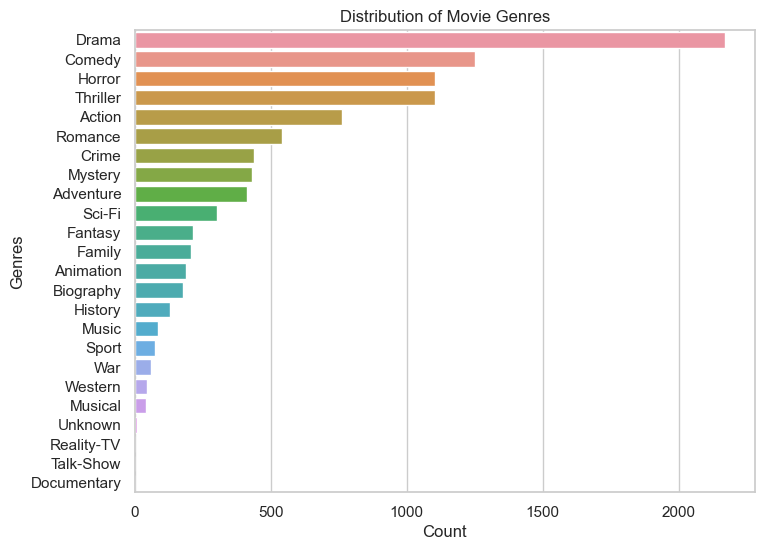

In [24]:
# Visualizing the frequency of each 'Genre' in the dataset
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(y=genre_list, order=pd.Series(genre_list).value_counts().index)
plt.title("Distribution of Movie Genres")
plt.xlabel("Count")
plt.ylabel("Genres")

**From this visualization the following points can be inferred : -**
1. In our dataset we have majority of the movies(~ 2400)which belong to the genre of Drama and almost half of the movies (~ 1400) belong to the genre of Comedy. 
2. For genres like Reality-TV or Talk-Show or Documentary there is rarely any movie which belongs to the dataset.
3. There are certain Unknown genres in the dataset (~10-50) where no information related to genre type of that particular movie is available on the IMDB portal. 

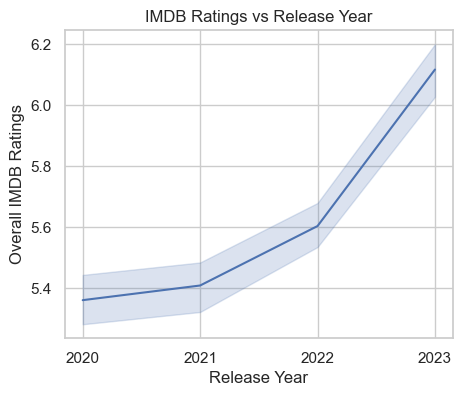

In [25]:
# Visualizing the relationship between 'IMDB Ratings' and 'Decade'
specific_years = [2020, 2021, 2022, 2023]
plt.figure(figsize=(5, 4))
sns.lineplot(x='Movie Release Year', y='Overall IMDB Rating', data=df)
plt.title('IMDB Ratings vs Release Year')
plt.ylabel('Overall IMDB Ratings')
plt.xlabel('Release Year')
plt.xticks(specific_years)
plt.show()

**From this visualization the following points can be inferred : -**
1. For the movies released in the year 2023, we have a higher average of IMDB Ratings as compared to other years.
2. Also, it can be inferred that movie viewers or customers actively started reviewing movies from the year 2023 onwards.
3. Between the years 2020-2023 there is a huge jump from ~5 in the year 2020 to ~6.1 in the year 2023 to in the average number of IMDB Ratings.  

#### Box plot to visualize the distribution of 'Overall IMDB Ratings' for each 'Movie Release Year.'

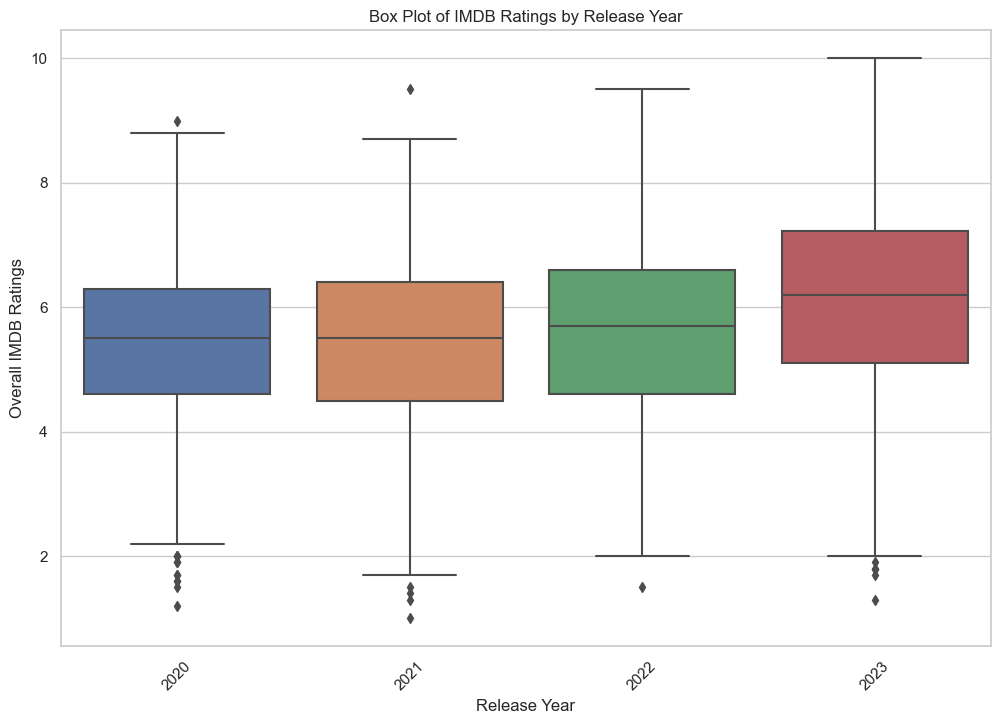

In [26]:
# Box plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Movie Release Year', y='Overall IMDB Rating', data=df)
plt.title('Box Plot of IMDB Ratings by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Overall IMDB Ratings')
plt.xticks(rotation=45)
plt.show()


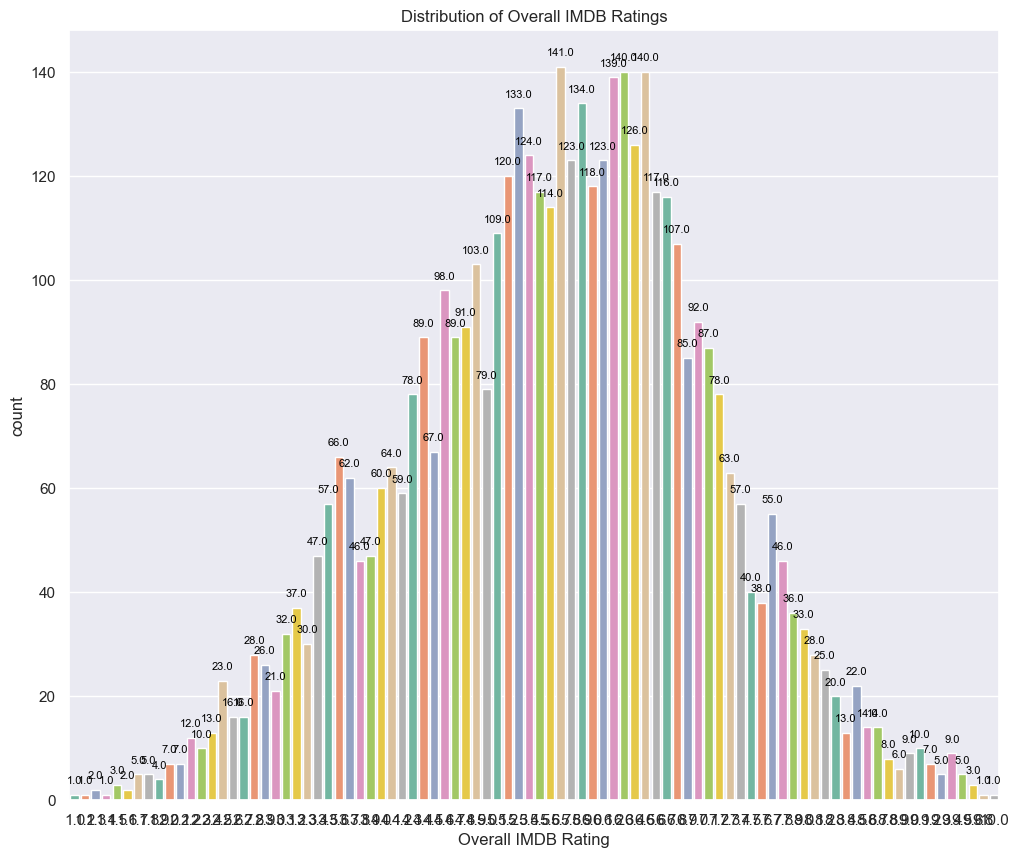

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.set(style="darkgrid")

# Sort IMDb ratings in ascending order from 1 to 10
sorted_ratings = sorted(df['Overall IMDB Rating'].unique())

ax = sns.countplot(x="Overall IMDB Rating", data=df, palette="Set2", order=sorted_ratings)

# Display count on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8, color='black')

plt.title('Distribution of Overall IMDB Ratings')
plt.show()


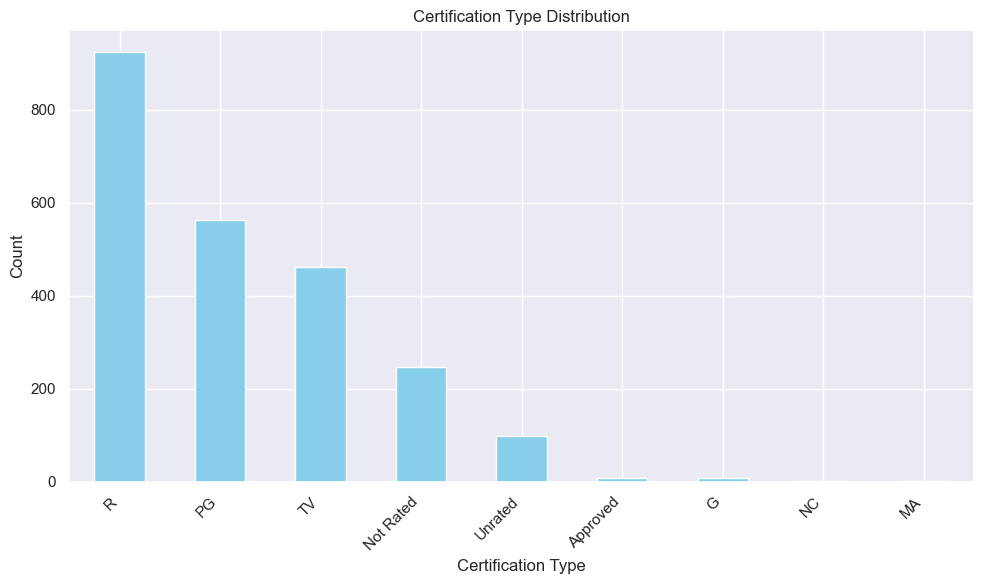

In [28]:
# Visulaizing the frequency distribution of 'Certification Type' thereby depicting the distribution of movies across
# different 'Certification Types'
certifications = df['Certification Type'].value_counts()
plt.figure(figsize=(10, 6))
certifications.plot(kind='bar', color='skyblue')
plt.title('Certification Type Distribution')
plt.xlabel('Certification Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**From this visualization the following points can be inferred : -**
1. For the Certification Type - R (Restricted) we have majority of the movies (~ 900) from our dataset where the children under the age of 17 years need parental/guardian guidance in order to watch that particular movie.  
2. PG Certificate is the certificate where parental guidance is suggested but not mandatory, from our dataset we have a count of (~ 550) where the movies have a certification type of PG.  
3. There are certain movies in the dataset as well (~ 100) where no information related to Certification Type can be captured from the IMDB portal. 

In [29]:
# Combining all 'Actor Names' into a single string
all_actors = [actor for actors_list in df['Actors List'] for actor in actors_list]

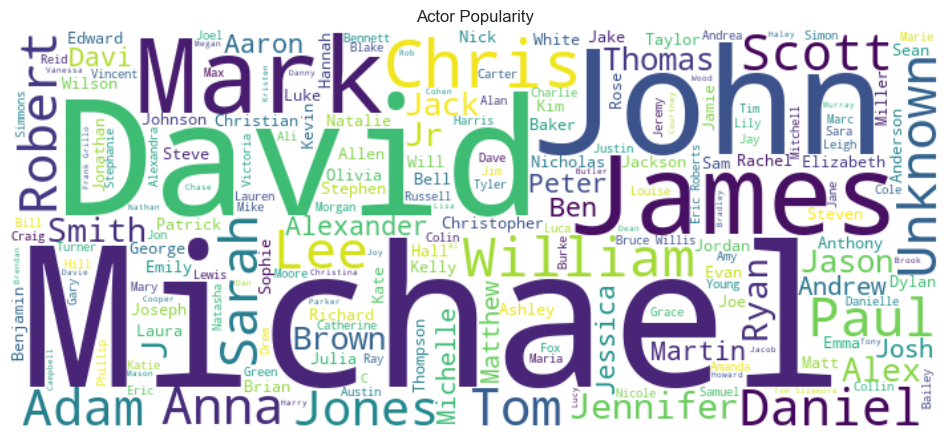

In [30]:
# Create a WordCloud object for identifying the 'Actor Names' which are the most popular ones 
actor_text = ' '.join(all_actors)
wordcloud = WordCloud(width=700, height=300, background_color='white', colormap='viridis', max_words=200).generate(actor_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Actor Popularity')
plt.show()

**From this visualization the following points can be inferred : -**
1. Some of the actor's which are the most popular ones among the dataset are - Michael, Chris, Sarah, Thomas, David, William etc...  
2. Some of the least popular actors among the dataset are - Toby, Peter, Haynes, Valeria, Anthony etc... 

In [31]:
# Creating an array of all genres
genre_list = [g for genres in df['Movie Genre'] for g in genres]

# Create a set of unique genres
unique_genres = list(set(genre_list))

# Initialize lists to store the 'Average Budget' and 'Revenue' for each genre
average_budgets = []
average_revenues = []

# Calculate the 'Average Budget' and 'Revenue' for each genre
for genre in unique_genres:
    genre_data = df[df['Movie Genre'].apply(lambda x: genre in x)]
    average_budget = genre_data['Total Budget'].mean()
    average_revenue = genre_data['Gross Worldwide'].mean()
    average_budgets.append(average_budget)
    average_revenues.append(average_revenue)

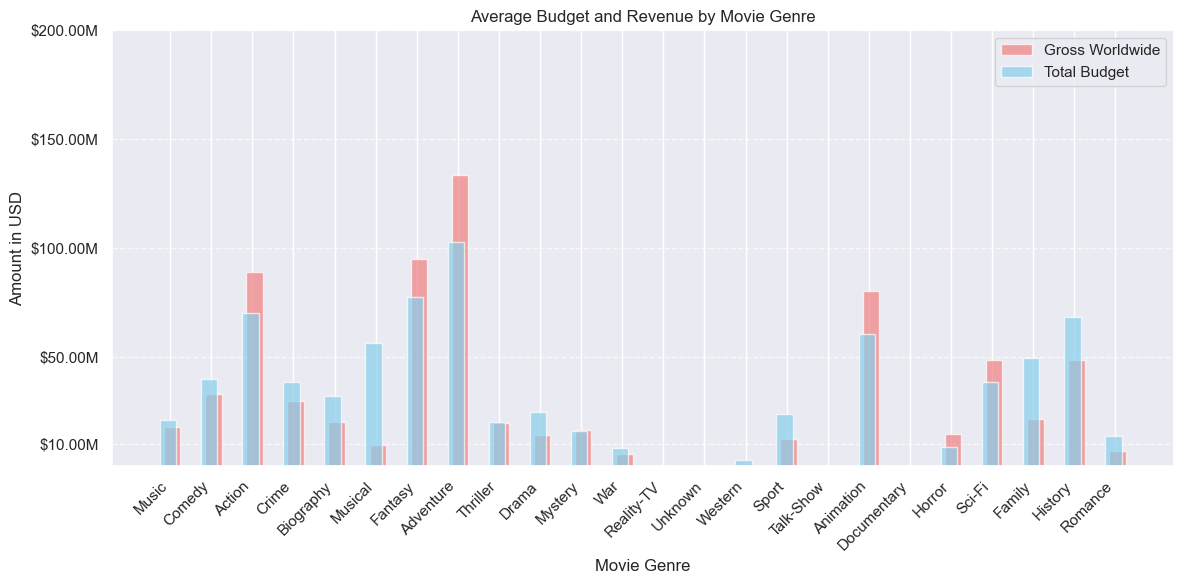

In [32]:
# Visulazing the 'Average Budget' & 'Revenue' by 'Movie Genere' to understand 
# how the genre of the movie impacts the overall budget and revenue of the movie  
plt.figure(figsize=(12, 6))
width = 0.4
bar_spacing = 0.1
x = np.arange(len(unique_genres))
revenue_bars = plt.bar(x + bar_spacing / 2, average_revenues, width, label='Gross Worldwide', color='lightcoral', alpha=0.7)
budget_bars = plt.bar(x - bar_spacing / 2, average_budgets, width, label='Total Budget', color='skyblue', alpha=0.7)
plt.xlabel('Movie Genre')
plt.ylabel('Amount in USD')
plt.title('Average Budget and Revenue by Movie Genre')
plt.xticks(x, unique_genres, rotation=45
           , ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
budget_min = min(min(average_budgets), min(average_revenues))
budget_max = max(max(average_budgets), max(average_revenues))
y_ticks = [10000000, 50000000, 100000000, 150000000, 200000000]
plt.yticks(y_ticks, [f'${val/1000000:.2f}M' for val in y_ticks])
plt.tight_layout()
plt.show()

**From this visualization the following points can be inferred : -**
1. For the genre Adventure the Gross Wordwide collection is more than 150M however the Overall Budget was just reaching out to 100M and hence the movies in this category actually had a lot of profit.     
2. For the genre Crime the Gross Wordwide collection is approximately 45M and the Overall Budget was just reaching out to 40M and hence the movies in this category actually had to bear a lot of losses.
3. For genre categories like Animation, Comedy, Adventure, Action, History etc.. the Gross Wordwide collection is more as compared to the Overall Budget hence it means that the movies in these categories were profitable.

In [33]:
# As we can observe, Adventure, Sci-Fi, Fantasy, Horror, Action, Animation, Mystery and Comedy 
# are the only categories of genre which earn more than they spend on the creation of a movie.
# Therefore, we will use only these genres, as top genres for our clustering.
top_genres = ['Adventure', 'Sci-Fi', 'Fantasy', 'Horror', 'Action', 'Animation', 'Mystery', 'Comedy']

In [34]:
# Filtering out data to check only for data having atleast one of the top genres
def has_target_genre(genres):
    return any(genre in genres for genre in top_genres)
genre_data = df[df['Movie Genre'].apply(has_target_genre)]
genre_data=genre_data.reset_index(drop=True)
genre_data

Movie Name  Total Votes  Movie Release Year  \
0                        Saw X        42235                2023   
1                     Saltburn          842                2023   
2       The Exorcist: Believer        22299                2023   
3                      Reptile        55937                2023   
4                  The Creator        47359                2023   
...                        ...          ...                 ...   
3156           Xanadu Hellfire          138                2022   
3157           The Replacement         1243                2021   
3158                 Blue Call          188                2021   
3159   The Beast of Walton St.            6                2022   
3160  Progressive Tailors Club           17                2021   

     Certification Type  Movie Duration                  Movie Genre  \
0                     R           118.0  [Horror, Mystery, Thriller]   
1                     R           127.0    [Comedy, Drama, Thriller]   
2                     R           111.0                     [Horror]   
3                     R           134.0      [Crime, Drama, Mystery]   
4                    PG           133.0   [Action, Adventure, Drama]   
...                 ...             ...                          ...   
3156                NaN           105.0                    [Fantasy]   
3157                NaN           117.0           [Action, Thriller]   
3158                NaN            81.0       [Crime, Drama, Horror]   
3159                NaN            95.0                     [Horror]   
3160                NaN           123.0                     [Comedy]   

      Overall IMDB Rating  Overall IMDB Ranking  \
0                     6.7                   5.0   
1                     7.1                   7.0   
2                     4.9                   8.0   
3                     6.8                   9.0   
4                     7.1                  12.0   
...                   ...                   ...   
3156                  4.1                   NaN   
3157                  6.4                   NaN   
3158                  3.9                   NaN   
3159                  9.4                   NaN   
3160                  6.4                   NaN   

                                             Movie Plot      Directors List  \
0     A sick and desperate John travels to Mexico fo...      Kevin Greutert   
1     A student at Oxford University finds himself d...     Emerald Fennell   
2     When two girls disappear into the woods and re...  David Gordon Green   
3     Tom Nichols is a hardened New England detectiv...        Grant Singer   
4     Against the backdrop of a war between humans a...      Gareth Edwards   
...                                                 ...                 ...   
3156  An eight-year-old girl finds a way to bring he...        Justin Armao   
3157  A young hardened police officer finds himself ...         Óscar Aibar   
3158  Haylee, a local EMT suffering from PTSD, spend...        Brian Farmer   
3159  As the homeless population of an Ohio town is ...        Dusty Austen   
3160  The Progressive Tailors Club gathers for a mee...      Biodun Stephen   

      ... Number of User Reviews IMDB Metascore  Total Oscar Nominations  \
0     ...                  357.0           60.0                      NaN   
1     ...                    8.0           62.0                      NaN   
2     ...                  420.0           39.0                      NaN   
3     ...                  284.0           52.0                      NaN   
4     ...                  529.0           63.0                      NaN   
...   ...                    ...            ...                      ...   
3156  ...                    8.0            NaN                      NaN   
3157  ...                    2.0            NaN                      NaN   
3158  ...                   11.0            NaN                      NaN   
3159  ...                   

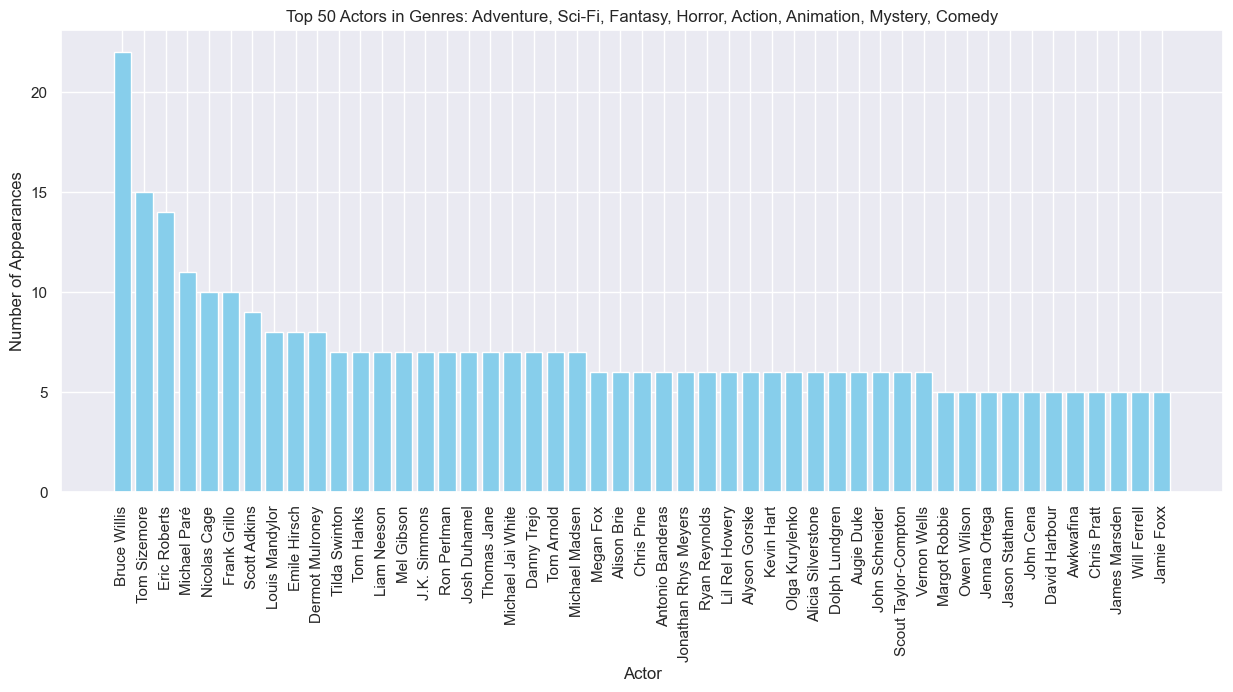

In [35]:
# Determining and Visualizing the 'Top 50 Actors' within the top genres
all_actors = genre_data['Actors List'].explode().dropna()
all_actors = all_actors.apply(lambda x: x.strip())

if not all_actors.empty:
    actor_counts = Counter(actor for actor in all_actors)                
    top_actors = dict(actor_counts.most_common(50))
    top_actors.pop('Unknown')
    plt.figure(figsize=(15, 6))
    plt.bar(top_actors.keys(), top_actors.values(), color='skyblue')
    plt.title(f'Top 50 Actors in Genres: {", ".join(top_genres)}')
    plt.xlabel('Actor')
    plt.ylabel('Number of Appearances')
    plt.xticks(rotation=90)
    plt.show()
    
else:
    print(f"No actors found for the specified genres: {top_genres}")

**From this visualization the following points can be inferred : -**
1. Bruce Willis is the most popular actor whose presence has dominated the movie industry from 2020-2023 as he is the only actor who has performed in more than 25 movies.    
2. Tom Sizemore, Michael Pare, Nicolas Cage are some of the artists who have just performed in 10-15 movies across the years 2020-2023.

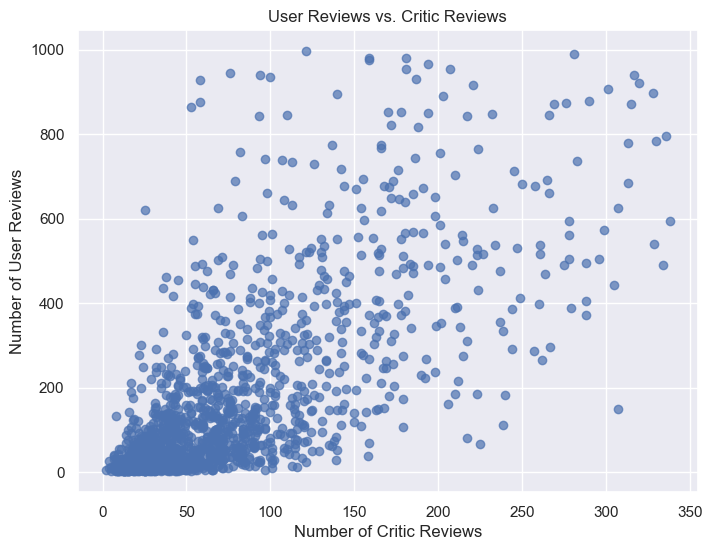

In [36]:
# Visualizing 'User Reviews' vs.'Critic Reviews'
plt.figure(figsize=(8, 6))
plt.scatter(df['Number of Critic Reviews'], df['Number of User Reviews'], alpha=0.7, color='b')
plt.title('User Reviews vs. Critic Reviews')
plt.xlabel('Number of Critic Reviews')
plt.ylabel('Number of User Reviews')
plt.grid(True)
plt.show()

**From this visualization the following points can be inferred : -**
1. The overall average of User Reviews and Critic Reviews is ~0-50 which means that users and critics have rated a movie in approximately equal proportions.    
2. The highest average number of Critic Reviews is ~ 1000 and the highest average number of User Reviews is ~ 800. 

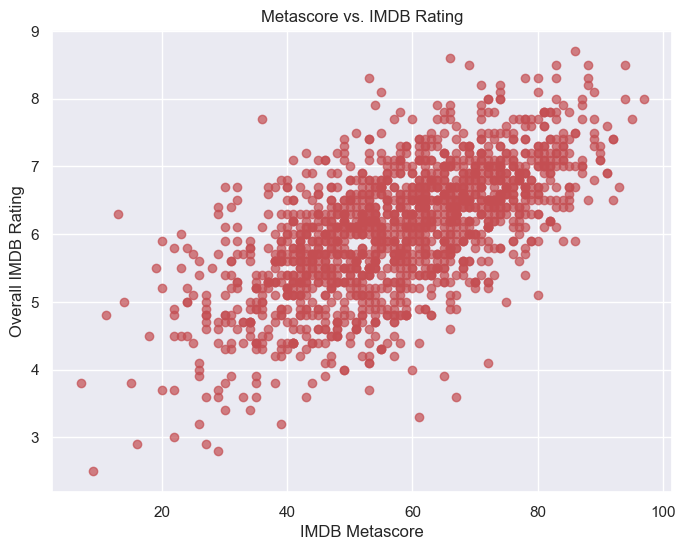

In [37]:
# Visualizing 'Metascore' vs.'IMDB Rating'
plt.figure(figsize=(8, 6))
plt.scatter(df['IMDB Metascore'], df['Overall IMDB Rating'], alpha=0.7, color='r')
plt.title('Metascore vs. IMDB Rating')
plt.xlabel('IMDB Metascore')
plt.ylabel('Overall IMDB Rating')
plt.grid(True)
plt.show()

**From this visualization the following points can be inferred : -**
1. IMDB Metascore is significantly similar to the IMDB Rating, since majority of the movies have IMDB Metascore and IMDB Rating both lying in the range of 40-80, which means that the reviews gathered from Metascore website by IMDB have an equal impact as IMDB in defining the IMDB Ratings for a movie.       
2. The highest average IMDB Metascore is ~ 9 and the highest average IMDB Rating is ~ 8. 

# 5. Handling Missing Values

In [38]:
# Identifying only numeric columns
numeric_columns = df.select_dtypes(include=['int', 'float']).columns
numeric_columns

Index(['Total Votes', 'Movie Release Year', 'Movie Duration',
       'Overall IMDB Rating', 'Overall IMDB Ranking',
       'Number of Critic Reviews', 'Number of User Reviews', 'IMDB Metascore',
       'Total Oscar Nominations', 'Total Oscar Won', 'Total Wins',
       'Total Nominations', 'Total Budget', 'Gross-US & Canada',
       'Opening Weekend-US & Canada', 'Gross Worldwide'],
      dtype='object')

In [39]:
# Extract only numeric columns for KNN imputation
df_numeric = df[numeric_columns]

In [40]:
# Fidning the percentage of missing values in each of the Numerical Features 
df_numeric.isna().sum()*100/len(df_numeric)

Total Votes                     0.000000
Movie Release Year              0.000000
Movie Duration                  2.577873
Overall IMDB Rating             0.000000
Overall IMDB Ranking           81.288937
Number of Critic Reviews       65.649839
Number of User Reviews         23.286788
IMDB Metascore                 65.542427
Total Oscar Nominations        99.527390
Total Oscar Won                99.763695
Total Wins                     64.103115
Total Nominations              69.151450
Total Budget                   83.308271
Gross-US & Canada              82.448980
Opening Weekend-US & Canada    88.034372
Gross Worldwide                61.933405
dtype: float64

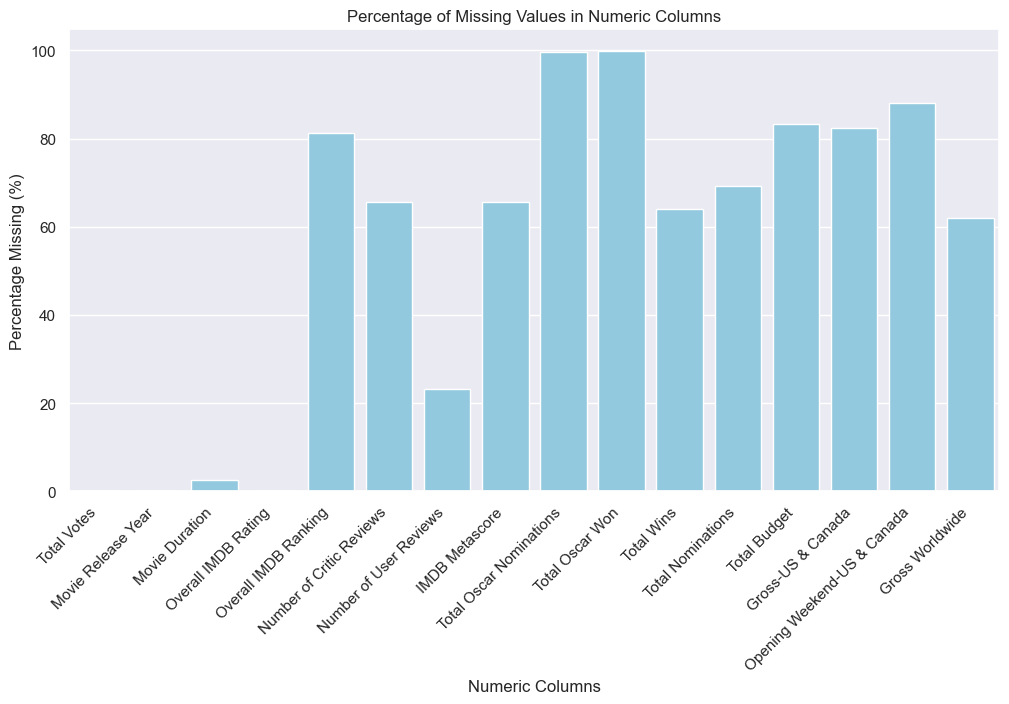

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the percentage of missing values
missing_percentage = df_numeric.isna().sum() * 100 / len(df_numeric)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage, color='skyblue')
plt.title('Percentage of Missing Values in Numeric Columns')
plt.xlabel('Numeric Columns')
plt.ylabel('Percentage Missing (%)')
plt.xticks(rotation=45, ha='right')
plt.show()


In [42]:
# Removing "Overall IMDB Ranking","Number of Critic Reviews","IMDB Metascore","Total Oscar Nominations",
# "Total Oscar Won","Total Wins","Total Nominations","Total Budget","Gross-US & Canada","Opening Weekend-US & Canada",
# "Gross Worldwide" as the number of missing values is greater than 65%
df_numeric=df_numeric.drop(columns=["Overall IMDB Ranking","Number of Critic Reviews","IMDB Metascore",
"Total Oscar Nominations","Total Oscar Won","Total Wins","Total Nominations","Total Budget","Gross-US & Canada",
"Opening Weekend-US & Canada","Gross Worldwide"])
df_numeric.head()

Total Votes  Movie Release Year  Movie Duration  Overall IMDB Rating  \
0        61151                2023           206.0                  8.1   
1        42235                2023           118.0                  6.7   
2         9876                2023           122.0                  6.5   
3          842                2023           127.0                  7.1   
4        22299                2023           111.0                  4.9   

   Number of User Reviews  
0                   505.0  
1                   357.0  
2                    58.0  
3                     8.0  
4                   420.0

In [43]:
# Creating a KNNImputer instance for imputing missing values
imputer = KNNImputer(n_neighbors=5) 

In [44]:
# df_imputed is redefined original DataFrame with missing values replaced by imputed values in Numerical columns
df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)
df_imputed = df_imputed.astype(int)

In [45]:
# Percentage of missing values after imputation in the numerical features
df_imputed.select_dtypes("number").isna().sum()*100/len(df)

Total Votes               0.0
Movie Release Year        0.0
Movie Duration            0.0
Overall IMDB Rating       0.0
Number of User Reviews    0.0
dtype: float64

In [46]:
# Dropping the columns from the original dataset which are having high percentage of missing values 
df=df.drop(columns=["Overall IMDB Ranking","Number of Critic Reviews","IMDB Metascore",
"Total Oscar Nominations","Total Oscar Won","Total Wins","Total Nominations","Total Budget","Gross-US & Canada",
"Opening Weekend-US & Canada","Gross Worldwide"])

# Replacing the columns in the original dataset with the ones after performinng KNN Imputation 
df["Total Votes"]=df_imputed["Total Votes"]
df["Movie Release Year"]=df_imputed["Movie Release Year"]
df["Movie Duration"]=df_imputed["Movie Duration"]
df["Overall IMDB Rating"]=df_imputed["Overall IMDB Rating"]
df["Number of User Reviews"]=df_imputed["Number of User Reviews"]
df=df.reset_index(drop=True)
df

Movie Name  Total Votes  Movie Release Year  \
0         Killers of the Flower Moon        61151                2023   
1                              Saw X        42235                2023   
2                      Pain Hustlers         9876                2023   
3                           Saltburn          842                2023   
4             The Exorcist: Believer        22299                2023   
...                              ...          ...                 ...   
4650                       Blue Call          188                2021   
4651         The Beast of Walton St.            6                2022   
4652                      Over/Under           28                2022   
4653  The Male Gaze: Three's Company          123                2021   
4654        Progressive Tailors Club           17                2021   

     Certification Type  Movie Duration                  Movie Genre  \
0                     R             206      [Crime, Drama, History]   
1                     R             118  [Horror, Mystery, Thriller]   
2                     R             122               [Crime, Drama]   
3                     R             127    [Comedy, Drama, Thriller]   
4                     R             111                     [Horror]   
...                 ...             ...                          ...   
4650                NaN              81       [Crime, Drama, Horror]   
4651                NaN              95                     [Horror]   
4652                NaN              88                      [Drama]   
4653                NaN              98                      [Drama]   
4654                NaN             123                     [Comedy]   

      Overall IMDB Rating                                         Movie Plot  \
0                       8  When oil is discovered in 1920s Oklahoma under...   
1                       6  A sick and desperate John travels to Mexico fo...   
2                       6  Liza dreams of a better life for herself and h...   
3                       7  A student at Oxford University finds himself d...   
4                       4  When two girls disappear into the woods and re...   
...                   ...                                                ...   
4650                    3  Haylee, a local EMT suffering from PTSD, spend...   
4651                    9  As the homeless population of an Ohio town is ...   
4652                    8  Childhood friendship can be a time of innocenc...   
4653                    4  Two's company, three's allowed? From family di...   
4654                    6  The Progressive Tailors Club gathers for a mee...   

                                         Directors List  \
0                                       Martin Scorsese   
1                                        Kevin Greutert   
2                                           David Yates   
3                                       Emerald Fennell   
4                                    David Gordon Green   
...                                                 ...   
4650                                       Brian Farmer   
4651                                       Dusty Austen   
4652                                      Sophia Silver   
4653  Raphaël Balboni, Richard Kranzin, Guillaume Ma...   
4654                                     Biodun Stephen   

                                           Writers List  \
0           [Eric Roth,  Martin Scorsese,  David Grann]   
1                     [Pete Goldfinger,  Josh Stolberg]   
2                           [Wells Tower,  Evan Hughes]   
3                                     [Emerald Fennell]   
4     [Peter Sattler,  David Gordon Green,  Scott Te...   
...                                                 ...   
4650                                     [Brian Farmer]   
4651                     [Dusty Austen,  Athena Murzda]   
4652                [Sophia Silver,  Sianni Rosenstock]   
4653                [Jér

**The choice of 'n_neighbors=5' in K-Nearest Neighbors (KNN) imputation strikes a balance between bias and variance. It allows for a moderate influence of nearby data points, capturing local patterns without being overly sensitive to outliers.**

# 6. Identifying and Removing Outliers

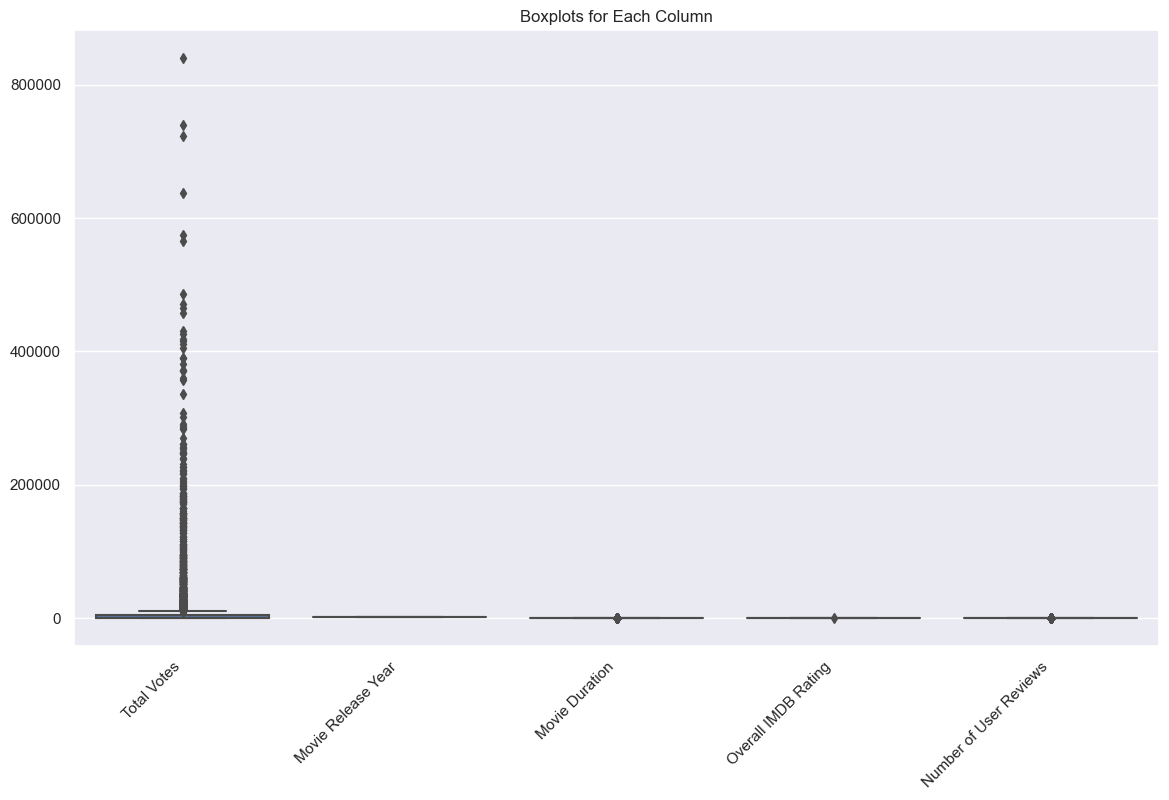

In [47]:
# Plotting a BoxPlot of the Dataset after handling missing values
plt.figure(figsize=(14, 8))
sns.boxplot(data=df)
plt.title('Boxplots for Each Column')
plt.xticks(rotation=45, ha='right')  
plt.show()

In [48]:
# Applying 'Quantile Based Flooring and Capping' to identify how the outliers are handled using this method 
floor_quantile = 0.05
cap_quantile = 0.95

df_flooring_capping=df.select_dtypes(include=['int', 'float'])

for i in df_flooring_capping.columns:
    floor_value = df_flooring_capping[i].quantile(floor_quantile)
    cap_value = df_flooring_capping[i].quantile(cap_quantile)
    df_flooring_capping[i] = np.clip(df_flooring_capping[i], floor_value, cap_value)
df_flooring_capping

Total Votes  Movie Release Year  Movie Duration  Overall IMDB Rating  \
0         59826.8                2023             130                  7.3   
1         42235.0                2023             118                  6.0   
2          9876.0                2023             122                  6.0   
3           842.0                2023             127                  7.0   
4         22299.0                2023             111                  4.0   
...           ...                 ...             ...                  ...   
4650        188.0                2021              81                  3.0   
4651         26.0                2022              95                  7.3   
4652         28.0                2022              88                  7.3   
4653        123.0                2021              98                  4.0   
4654         26.0                2021             123                  6.0   

      Number of User Reviews  
0                        505  
1                        357  
2                         58  
3                          8  
4                        420  
...                      ...  
4650                      11  
4651                       2  
4652                       3  
4653                       3  
4654                       2  

[4655 rows x 5 columns]

In [49]:
# Applying 'Trimming' to identify how the outliers are handled using this method
df_trimmed = df.select_dtypes(include=['int', 'float'])

Q1 = df_trimmed.quantile(0.25)
Q3 = df_trimmed.quantile(0.75)
IQR = Q3 - Q1

outlier_threshold = 1.5
lower_bound = Q1 - outlier_threshold * IQR
upper_bound = Q3 + outlier_threshold * IQR

trim_percent = 0.05

for col in df_trimmed.columns:
    lower_bound = df_trimmed[col].quantile(trim_percent)
    upper_bound = df_trimmed[col].quantile(1 - trim_percent)
    df_trimmed[col] = df_trimmed[col][(df_trimmed[col] >= lower_bound) & (df_trimmed[col] <= upper_bound)]
df_trimmed   

Total Votes  Movie Release Year  Movie Duration  Overall IMDB Rating  \
0             NaN                2023             NaN                  NaN   
1         42235.0                2023           118.0                  6.0   
2          9876.0                2023           122.0                  6.0   
3           842.0                2023           127.0                  7.0   
4         22299.0                2023           111.0                  4.0   
...           ...                 ...             ...                  ...   
4650        188.0                2021            81.0                  3.0   
4651          NaN                2022            95.0                  NaN   
4652         28.0                2022            88.0                  NaN   
4653        123.0                2021            98.0                  4.0   
4654          NaN                2021           123.0                  6.0   

      Number of User Reviews  
0                      505.0  
1                      357.0  
2                       58.0  
3                        8.0  
4                      420.0  
...                      ...  
4650                    11.0  
4651                     2.0  
4652                     3.0  
4653                     3.0  
4654                     2.0  

[4655 rows x 5 columns]

In [50]:
# Applying 'Log Transformation' to identify how the outliers are handled using this method
cols_to_transform =  df.select_dtypes(include=['int', 'float']).columns
df_log_transformed =  df.select_dtypes(include=['int', 'float'])
df_log_transformed[cols_to_transform] = df_log_transformed[cols_to_transform].apply(lambda x: np.log1p(x))
df_log_transformed

Total Votes  Movie Release Year  Movie Duration  Overall IMDB Rating  \
0       11.021118            7.612831        5.332719             2.197225   
1       10.651028            7.612831        4.779123             1.945910   
2        9.197964            7.612831        4.812184             1.945910   
3        6.736967            7.612831        4.852030             2.079442   
4       10.012342            7.612831        4.718499             1.609438   
...           ...                 ...             ...                  ...   
4650     5.241747            7.611842        4.406719             1.386294   
4651     1.945910            7.612337        4.564348             2.302585   
4652     3.367296            7.612337        4.488636             2.197225   
4653     4.820282            7.611842        4.595120             1.609438   
4654     2.890372            7.611842        4.820282             1.945910   

      Number of User Reviews  
0                   6.226537  
1                   5.880533  
2                   4.077537  
3                   2.197225  
4                   6.042633  
...                      ...  
4650                2.484907  
4651                1.098612  
4652                1.386294  
4653                1.386294  
4654                1.098612  

[4655 rows x 5 columns]

Text(0.5, 1.0, 'Quantile-Based Flooring and Capping')

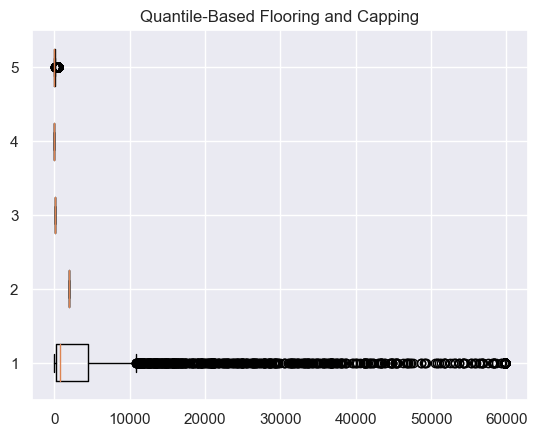

In [51]:
# Visualizing the Outlier detection techniques used - Quantile-based Flooring and Capping
plt.subplot(111)
plt.boxplot(df_flooring_capping,vert=False)
plt.title('Quantile-Based Flooring and Capping')

Text(0.5, 1.0, 'Trimming')

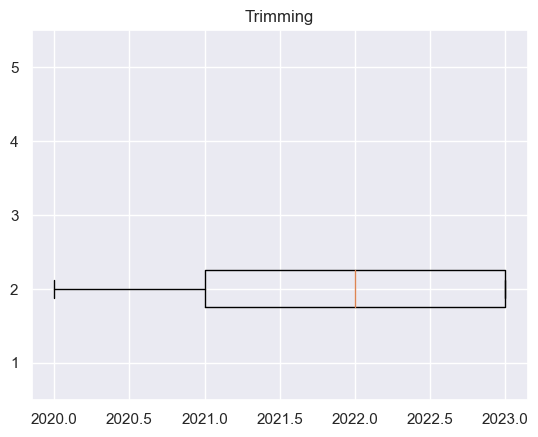

In [52]:
# Visualizing the Outlier detection techniques used - Trimming
plt.subplot(111)
plt.boxplot(df_trimmed,vert=False)
plt.title('Trimming')

Text(0.5, 1.0, 'Log Transformation')

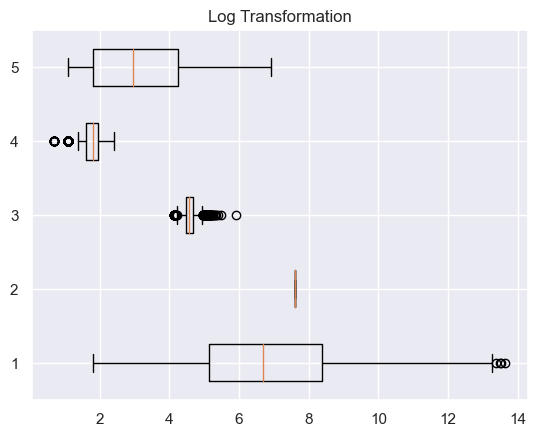

In [53]:
# Visualizing the Outlier detection techniques used - Trimming
plt.subplot(111)
plt.boxplot(df_log_transformed,vert=False)
plt.title('Log Transformation')

**After a thorough analysis of various outlier handling techniques, like Quantile-Based Flooring and Capping, Log Transformation, and Trimming, we have chosen Quantile-Based Flooring and Capping as the most effective option.The reason being that if we use Trimming we still have some of the NULL values in the dataset and incase if we use Log Transformation then the year values-2020,2021,2022,2023 are tranformed according to Log values which is not a feasible solution.** 

In [54]:
# Using 'Quantile Based Floor and Capping' on our numerical dataset obtained from the original dataset to handle the outliers
floor_quantile = 0.05
cap_quantile = 0.95

df_flooring_capping_final=df.select_dtypes(include=['int', 'float'])

for i in df_flooring_capping_final.columns:
    floor_value = df_flooring_capping_final[i].quantile(floor_quantile)
    cap_value = df_flooring_capping_final[i].quantile(cap_quantile)
    df_flooring_capping_final[i] = np.clip(df_flooring_capping_final[i], floor_value, cap_value)
df_flooring_capping_final

Total Votes  Movie Release Year  Movie Duration  Overall IMDB Rating  \
0         59826.8                2023             130                  7.3   
1         42235.0                2023             118                  6.0   
2          9876.0                2023             122                  6.0   
3           842.0                2023             127                  7.0   
4         22299.0                2023             111                  4.0   
...           ...                 ...             ...                  ...   
4650        188.0                2021              81                  3.0   
4651         26.0                2022              95                  7.3   
4652         28.0                2022              88                  7.3   
4653        123.0                2021              98                  4.0   
4654         26.0                2021             123                  6.0   

      Number of User Reviews  
0                        505  
1                        357  
2                         58  
3                          8  
4                        420  
...                      ...  
4650                      11  
4651                       2  
4652                       3  
4653                       3  
4654                       2  

[4655 rows x 5 columns]

In [55]:
# Replacing the columns in the original dataset with the ones after performinng Outlier Removal Technique-Trimming 
# on numerical datset 
df["Total Votes"]=df_flooring_capping_final["Total Votes"]
df["Movie Release Year"]=df_flooring_capping_final["Movie Release Year"]
df["Movie Duration"]=df_flooring_capping_final["Movie Duration"]
df["Overall IMDB Rating"]=df_flooring_capping_final["Overall IMDB Rating"]
df["Number of User Reviews"]=df_flooring_capping_final["Number of User Reviews"]
df=df.reset_index(drop=True)
df

Movie Name  Total Votes  Movie Release Year  \
0         Killers of the Flower Moon      59826.8                2023   
1                              Saw X      42235.0                2023   
2                      Pain Hustlers       9876.0                2023   
3                           Saltburn        842.0                2023   
4             The Exorcist: Believer      22299.0                2023   
...                              ...          ...                 ...   
4650                       Blue Call        188.0                2021   
4651         The Beast of Walton St.         26.0                2022   
4652                      Over/Under         28.0                2022   
4653  The Male Gaze: Three's Company        123.0                2021   
4654        Progressive Tailors Club         26.0                2021   

     Certification Type  Movie Duration                  Movie Genre  \
0                     R             130      [Crime, Drama, History]   
1                     R             118  [Horror, Mystery, Thriller]   
2                     R             122               [Crime, Drama]   
3                     R             127    [Comedy, Drama, Thriller]   
4                     R             111                     [Horror]   
...                 ...             ...                          ...   
4650                NaN              81       [Crime, Drama, Horror]   
4651                NaN              95                     [Horror]   
4652                NaN              88                      [Drama]   
4653                NaN              98                      [Drama]   
4654                NaN             123                     [Comedy]   

      Overall IMDB Rating                                         Movie Plot  \
0                     7.3  When oil is discovered in 1920s Oklahoma under...   
1                     6.0  A sick and desperate John travels to Mexico fo...   
2                     6.0  Liza dreams of a better life for herself and h...   
3                     7.0  A student at Oxford University finds himself d...   
4                     4.0  When two girls disappear into the woods and re...   
...                   ...                                                ...   
4650                  3.0  Haylee, a local EMT suffering from PTSD, spend...   
4651                  7.3  As the homeless population of an Ohio town is ...   
4652                  7.3  Childhood friendship can be a time of innocenc...   
4653                  4.0  Two's company, three's allowed? From family di...   
4654                  6.0  The Progressive Tailors Club gathers for a mee...   

                                         Directors List  \
0                                       Martin Scorsese   
1                                        Kevin Greutert   
2                                           David Yates   
3                                       Emerald Fennell   
4                                    David Gordon Green   
...                                                 ...   
4650                                       Brian Farmer   
4651                                       Dusty Austen   
4652                                      Sophia Silver   
4653  Raphaël Balboni, Richard Kranzin, Guillaume Ma...   
4654                                     Biodun Stephen   

                                           Writers List  \
0           [Eric Roth,  Martin Scorsese,  David Grann]   
1                     [Pete Goldfinger,  Josh Stolberg]   
2                           [Wells Tower,  Evan Hughes]   
3                                     [Emerald Fennell]   
4     [Peter Sattler,  David Gordon Green,  Scott Te...   
...                                                 ...   
4650                                     [Brian Farmer]   
4651                     [Dusty Austen,  Athena Murzda]   
4652                [Sophia Silver,  Sianni Rosenstock]   
4653                [Jér

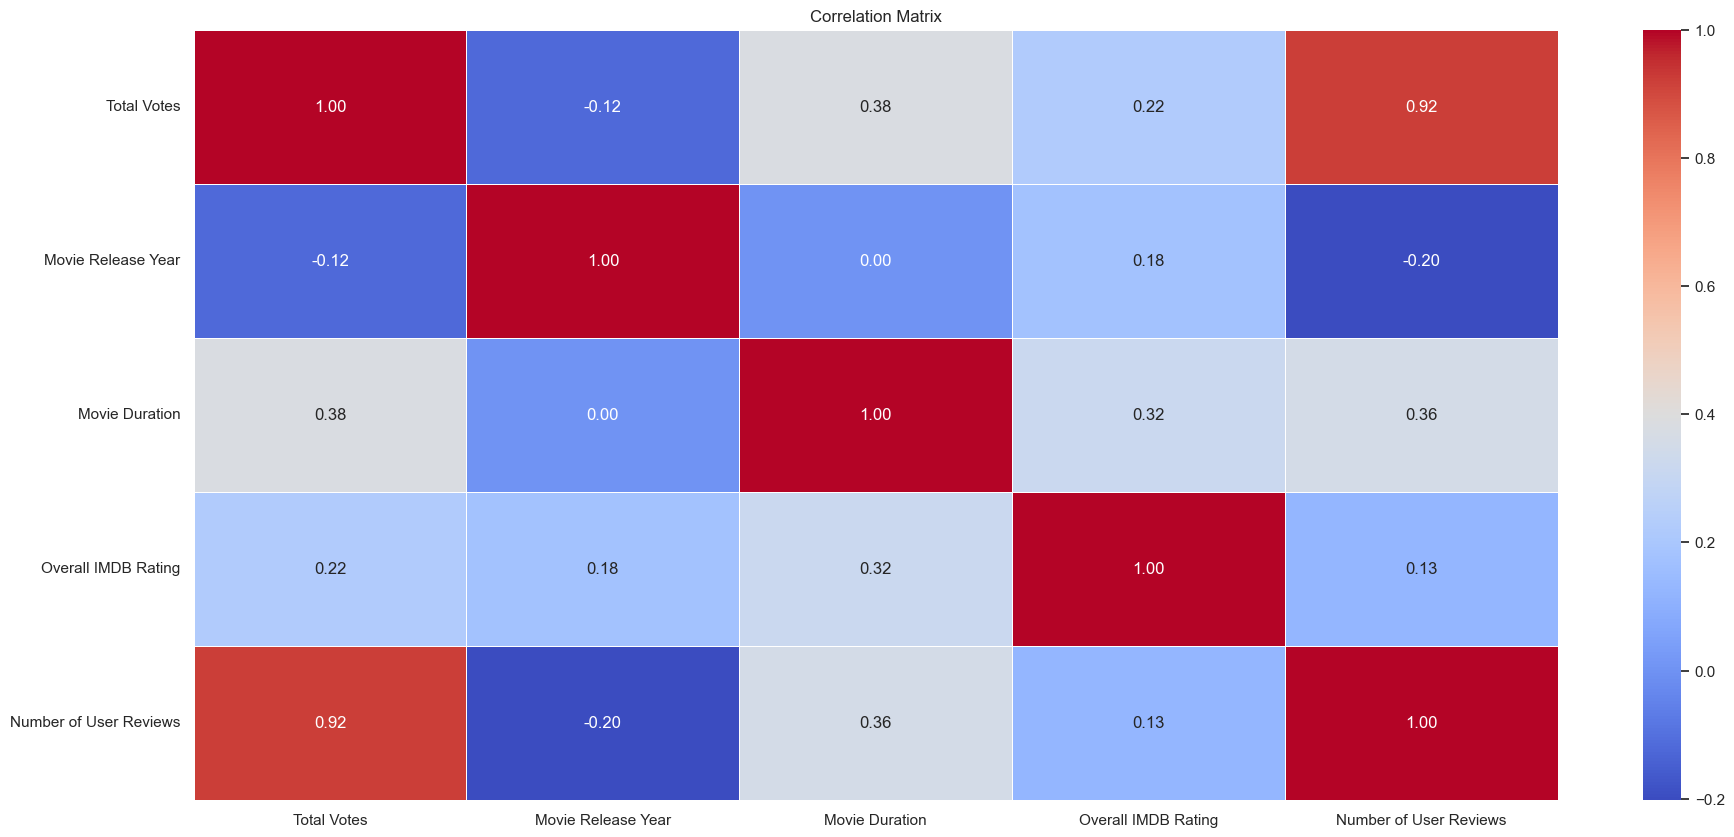

In [56]:
# Create a Heatmap of the Correlation Matrix to understand the relationship among features
# of the Dataset after removing NULL Values and Outliers
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(22, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

**From this visualization the following points can be inferred : -**
1. Based on the correlation coefficients, it's evident that Total Votes strongly correlate with Number of User Reviews with a coorelation value of 0.92.     
2. There's a notable positive correlation between Number of Movie Reviews and Movie Duration i.e 0.36 which means that the IMDB Ratings are somewhat influenced by the Movie Duration.   

# 7. Pandas Profiling

In [58]:
# profile_report = ProfileReport(df)
# profile_report.to_file("Pandas_Profiling_Report.html")

# 8. Feature Engineering

In [59]:
# Adding a feature of 'Feature Decade' to identify the decade of the movie
df['Release Decade'] = (df['Movie Release Year'] // 10) * 10

In [60]:
# Adding a feature of 'Age of the Movie' to identify the time since the movie is released
current_year = pd.to_datetime('today').year
df['Age of the Movie'] = current_year - df['Movie Release Year']

In [61]:
# Adding a feature of 'Release Season' to identify the Weather Season in which movie is released 
df['Release Season'] = pd.to_datetime(df['Movie Release Year'], format='%Y').dt.month.map(
    {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})

In [62]:
# Getting a glimpse of dataset after feature engineering
df.head()

Movie Name  Total Votes  Movie Release Year  \
0  Killers of the Flower Moon      59826.8                2023   
1                       Saw X      42235.0                2023   
2               Pain Hustlers       9876.0                2023   
3                    Saltburn        842.0                2023   
4      The Exorcist: Believer      22299.0                2023   

  Certification Type  Movie Duration                  Movie Genre  \
0                  R             130      [Crime, Drama, History]   
1                  R             118  [Horror, Mystery, Thriller]   
2                  R             122               [Crime, Drama]   
3                  R             127    [Comedy, Drama, Thriller]   
4                  R             111                     [Horror]   

   Overall IMDB Rating                                         Movie Plot  \
0                  7.3  When oil is discovered in 1920s Oklahoma under...   
1                  6.0  A sick and desperate John travels to Mexico fo...   
2                  6.0  Liza dreams of a better life for herself and h...   
3                  7.0  A student at Oxford University finds himself d...   
4                  4.0  When two girls disappear into the woods and re...   

       Directors List                                       Writers List  \
0     Martin Scorsese        [Eric Roth,  Martin Scorsese,  David Grann]   
1      Kevin Greutert                  [Pete Goldfinger,  Josh Stolberg]   
2         David Yates                        [Wells Tower,  Evan Hughes]   
3     Emerald Fennell                                  [Emerald Fennell]   
4  David Gordon Green  [Peter Sattler,  David Gordon Green,  Scott Te...   

                                         Actors List  Number of User Reviews  \
0  [Leonardo DiCaprio,  Robert De Niro,  Lily Gla...                     505   
1  [Tobin Bell,  Shawnee Smith,  Synnøve Macody L...                     357   
2     [Emily Blunt,  Chris Evans,  Catherine O'Hara]                      58   
3    [Barry Keoghan,  Jacob Elordi,  Archie Madekwe]                       8   
4  [Lafortune Joseph,  Leslie Odom Jr.,  Gastner ...                     420   

   Release Decade  Age of the Movie Release Season  
0            2020                 0         Winter  
1            2020                 0         Winter  
2            2020                 0         Winter  
3            2020                 0         Winter  
4            2020                 0         Winter

# 9. One Hot Encoding

In [63]:
# Apply one-hot encoding to the 'Certification Type' column
encoder = OneHotEncoder(sparse=False, drop='first')
certification_encoded = pd.DataFrame(encoder.fit_transform(df[['Certification Type']]), columns=encoder.get_feature_names_out(['Certification Type']))

C:\Users\Sufia Shaikh\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [64]:
# Concatenating the encoded features with the original cleaned dataset
df = pd.concat([df, certification_encoded], axis=1)
df

Movie Name  Total Votes  Movie Release Year  \
0         Killers of the Flower Moon      59826.8                2023   
1                              Saw X      42235.0                2023   
2                      Pain Hustlers       9876.0                2023   
3                           Saltburn        842.0                2023   
4             The Exorcist: Believer      22299.0                2023   
...                              ...          ...                 ...   
4650                       Blue Call        188.0                2021   
4651         The Beast of Walton St.         26.0                2022   
4652                      Over/Under         28.0                2022   
4653  The Male Gaze: Three's Company        123.0                2021   
4654        Progressive Tailors Club         26.0                2021   

     Certification Type  Movie Duration                  Movie Genre  \
0                     R             130      [Crime, Drama, History]   
1                     R             118  [Horror, Mystery, Thriller]   
2                     R             122               [Crime, Drama]   
3                     R             127    [Comedy, Drama, Thriller]   
4                     R             111                     [Horror]   
...                 ...             ...                          ...   
4650                NaN              81       [Crime, Drama, Horror]   
4651                NaN              95                     [Horror]   
4652                NaN              88                      [Drama]   
4653                NaN              98                      [Drama]   
4654                NaN             123                     [Comedy]   

      Overall IMDB Rating                                         Movie Plot  \
0                     7.3  When oil is discovered in 1920s Oklahoma under...   
1                     6.0  A sick and desperate John travels to Mexico fo...   
2                     6.0  Liza dreams of a better life for herself and h...   
3                     7.0  A student at Oxford University finds himself d...   
4                     4.0  When two girls disappear into the woods and re...   
...                   ...                                                ...   
4650                  3.0  Haylee, a local EMT suffering from PTSD, spend...   
4651                  7.3  As the homeless population of an Ohio town is ...   
4652                  7.3  Childhood friendship can be a time of innocenc...   
4653                  4.0  Two's company, three's allowed? From family di...   
4654                  6.0  The Progressive Tailors Club gathers for a mee...   

                                         Directors List  \
0                                       Martin Scorsese   
1                                        Kevin Greutert   
2                                           David Yates   
3                                       Emerald Fennell   
4                                    David Gordon Green   
...                                                 ...   
4650                                       Brian Farmer   
4651                                       Dusty Austen   
4652                                      Sophia Silver   
4653  Raphaël Balboni, Richard Kranzin, Guillaume Ma...   
4654                                     Biodun Stephen   

                                           Writers List  ... Release Season  \
0           [Eric Roth,  Martin Scorsese,  David Grann]  ...         Winter   
1                     [Pete Goldfinger,  Josh Stolberg]  ...         Winter   
2                           [Wells Tower,  Evan Hughes]  ...         Winter   
3                                     [Emerald Fennell]  ...         Winter   
4     [Peter Sattler,  David Gordon Green,  Scott Te...  ...         Winter   
...                                                 ...  ...            ...   
4650                                     [Brian Farmer]  ... 

In [65]:
# Drop the original 'Certification Type' column
df = df.drop(['Certification Type'], axis=1)
df

Movie Name  Total Votes  Movie Release Year  \
0         Killers of the Flower Moon      59826.8                2023   
1                              Saw X      42235.0                2023   
2                      Pain Hustlers       9876.0                2023   
3                           Saltburn        842.0                2023   
4             The Exorcist: Believer      22299.0                2023   
...                              ...          ...                 ...   
4650                       Blue Call        188.0                2021   
4651         The Beast of Walton St.         26.0                2022   
4652                      Over/Under         28.0                2022   
4653  The Male Gaze: Three's Company        123.0                2021   
4654        Progressive Tailors Club         26.0                2021   

      Movie Duration                  Movie Genre  Overall IMDB Rating  \
0                130      [Crime, Drama, History]                  7.3   
1                118  [Horror, Mystery, Thriller]                  6.0   
2                122               [Crime, Drama]                  6.0   
3                127    [Comedy, Drama, Thriller]                  7.0   
4                111                     [Horror]                  4.0   
...              ...                          ...                  ...   
4650              81       [Crime, Drama, Horror]                  3.0   
4651              95                     [Horror]                  7.3   
4652              88                      [Drama]                  7.3   
4653              98                      [Drama]                  4.0   
4654             123                     [Comedy]                  6.0   

                                             Movie Plot  \
0     When oil is discovered in 1920s Oklahoma under...   
1     A sick and desperate John travels to Mexico fo...   
2     Liza dreams of a better life for herself and h...   
3     A student at Oxford University finds himself d...   
4     When two girls disappear into the woods and re...   
...                                                 ...   
4650  Haylee, a local EMT suffering from PTSD, spend...   
4651  As the homeless population of an Ohio town is ...   
4652  Childhood friendship can be a time of innocenc...   
4653  Two's company, three's allowed? From family di...   
4654  The Progressive Tailors Club gathers for a mee...   

                                         Directors List  \
0                                       Martin Scorsese   
1                                        Kevin Greutert   
2                                           David Yates   
3                                       Emerald Fennell   
4                                    David Gordon Green   
...                                                 ...   
4650                                       Brian Farmer   
4651                                       Dusty Austen   
4652                                      Sophia Silver   
4653  Raphaël Balboni, Richard Kranzin, Guillaume Ma...   
4654                                     Biodun Stephen   

                                           Writers List  \
0           [Eric Roth,  Martin Scorsese,  David Grann]   
1                     [Pete Goldfinger,  Josh Stolberg]   
2                           [Wells Tower,  Evan Hughes]   
3                                     [Emerald Fennell]   
4     [Peter Sattler,  David Gordon Green,  Scott Te...   
...                                                 ...   
4650                                     [Brian Farmer]   
4651                     [Dusty Austen,  Athena Murzda]   
4652                [Sophia Silver,  Sianni Rosenstock]   
4653                [Jérémie Dubois,  Andrew Musselman]   
4654    [Bunmi Ajakaiye,  Yusuf Carew,  Amaka Chidioka]   

                                            Actors List  ...  Release Season  \
0     [Leonardo DiCaprio,  Robert De Niro,  Lily Gla.

In [66]:
# Dropping the 'Movie Plot' column since we are not using that in modelling the dataset
df = df.drop(['Movie Plot'], axis=1)
df

Movie Name  Total Votes  Movie Release Year  \
0         Killers of the Flower Moon      59826.8                2023   
1                              Saw X      42235.0                2023   
2                      Pain Hustlers       9876.0                2023   
3                           Saltburn        842.0                2023   
4             The Exorcist: Believer      22299.0                2023   
...                              ...          ...                 ...   
4650                       Blue Call        188.0                2021   
4651         The Beast of Walton St.         26.0                2022   
4652                      Over/Under         28.0                2022   
4653  The Male Gaze: Three's Company        123.0                2021   
4654        Progressive Tailors Club         26.0                2021   

      Movie Duration                  Movie Genre  Overall IMDB Rating  \
0                130      [Crime, Drama, History]                  7.3   
1                118  [Horror, Mystery, Thriller]                  6.0   
2                122               [Crime, Drama]                  6.0   
3                127    [Comedy, Drama, Thriller]                  7.0   
4                111                     [Horror]                  4.0   
...              ...                          ...                  ...   
4650              81       [Crime, Drama, Horror]                  3.0   
4651              95                     [Horror]                  7.3   
4652              88                      [Drama]                  7.3   
4653              98                      [Drama]                  4.0   
4654             123                     [Comedy]                  6.0   

                                         Directors List  \
0                                       Martin Scorsese   
1                                        Kevin Greutert   
2                                           David Yates   
3                                       Emerald Fennell   
4                                    David Gordon Green   
...                                                 ...   
4650                                       Brian Farmer   
4651                                       Dusty Austen   
4652                                      Sophia Silver   
4653  Raphaël Balboni, Richard Kranzin, Guillaume Ma...   
4654                                     Biodun Stephen   

                                           Writers List  \
0           [Eric Roth,  Martin Scorsese,  David Grann]   
1                     [Pete Goldfinger,  Josh Stolberg]   
2                           [Wells Tower,  Evan Hughes]   
3                                     [Emerald Fennell]   
4     [Peter Sattler,  David Gordon Green,  Scott Te...   
...                                                 ...   
4650                                     [Brian Farmer]   
4651                     [Dusty Austen,  Athena Murzda]   
4652                [Sophia Silver,  Sianni Rosenstock]   
4653                [Jérémie Dubois,  Andrew Musselman]   
4654    [Bunmi Ajakaiye,  Yusuf Carew,  Amaka Chidioka]   

                                            Actors List  \
0     [Leonardo DiCaprio,  Robert De Niro,  Lily Gla...   
1     [Tobin Bell,  Shawnee Smith,  Synnøve Macody L...   
2        [Emily Blunt,  Chris Evans,  Catherine O'Hara]   
3       [Barry Keoghan,  Jacob Elordi,  Archie Madekwe]   
4     [Lafortune Joseph,  Leslie Odom Jr.,  Gastner ...   
...                                                 ...   
4650  [Katie Leclerc,  Andrea Sixtos,  Brian Tyler C...   
4651  [Aimee-Lynn Chadwick,  LaVail Duncan,  James L...   
4652  [Emajean Bullock,  Anastasia Veronica Lee,  Ad...   
4653   [Antoine Gouy,  Michael Muller,  Satya Dusaugey]   
4654  [Adesina Adebayo,  Alakija Adebayo,  Femi Adeb...   

      Number of User Reviews  ...  Release Season  Certification Type_G  \
0                        505  ...          Winter         

# 10. Modelling

In [67]:
# Filter 'Movies' based on the target 'Genres'
genre_movies = df[df['Movie Genre'].apply(lambda x: any(genre in top_genres for genre in x))]
genre_movies

Movie Name  Total Votes  Movie Release Year  \
1                        Saw X      42235.0                2023   
3                     Saltburn        842.0                2023   
4       The Exorcist: Believer      22299.0                2023   
5                      Reptile      55937.0                2023   
7                  The Creator      47359.0                2023   
...                        ...          ...                 ...   
4648           Xanadu Hellfire        138.0                2022   
4649           The Replacement       1243.0                2021   
4650                 Blue Call        188.0                2021   
4651   The Beast of Walton St.         26.0                2022   
4654  Progressive Tailors Club         26.0                2021   

      Movie Duration                  Movie Genre  Overall IMDB Rating  \
1                118  [Horror, Mystery, Thriller]                  6.0   
3                127    [Comedy, Drama, Thriller]                  7.0   
4                111                     [Horror]                  4.0   
5                130      [Crime, Drama, Mystery]                  6.0   
7                130   [Action, Adventure, Drama]                  7.0   
...              ...                          ...                  ...   
4648             105                    [Fantasy]                  4.0   
4649             117           [Action, Thriller]                  6.0   
4650              81       [Crime, Drama, Horror]                  3.0   
4651              95                     [Horror]                  7.3   
4654             123                     [Comedy]                  6.0   

          Directors List                                       Writers List  \
1         Kevin Greutert                  [Pete Goldfinger,  Josh Stolberg]   
3        Emerald Fennell                                  [Emerald Fennell]   
4     David Gordon Green  [Peter Sattler,  David Gordon Green,  Scott Te...   
5           Grant Singer  [Grant Singer,  Benjamin Brewer,  Benicio Del ...   
7         Gareth Edwards                     [Gareth Edwards,  Chris Weitz]   
...                  ...                                                ...   
4648        Justin Armao                                     [Justin Armao]   
4649         Óscar Aibar               [Óscar Aibar,  María Luisa Calderón]   
4650        Brian Farmer                                     [Brian Farmer]   
4651        Dusty Austen                     [Dusty Austen,  Athena Murzda]   
4654      Biodun Stephen    [Bunmi Ajakaiye,  Yusuf Carew,  Amaka Chidioka]   

                                            Actors List  \
1     [Tobin Bell,  Shawnee Smith,  Synnøve Macody L...   
3       [Barry Keoghan,  Jacob Elordi,  Archie Madekwe]   
4     [Lafortune Joseph,  Leslie Odom Jr.,  Gastner ...   
5     [Benicio Del Toro,  Justin Timberlake,  Eric B...   
7     [John David Washington,  Madeleine Yuna Voyles...   
...                                                 ...   
4648          [Macy Minear,  Aria Surrec,  Ryon Thomas]   
4649        [Ricardo Gómez,  Vicky Luengo,  Pere Ponce]   
4650  [Katie Leclerc,  Andrea Sixtos,  Brian Tyler C...   
4651  [Aimee-Lynn Chadwick,  LaVail Duncan,  James L...   
4654  [Adesina Adebayo,  Alakija Adebayo,  Femi Adeb...   

      Number of User Reviews  ...  Release Season  Certification Type_G  \
1                        357  ...          Winter                   0.0   
3                          8  ...          Winter                   0.0   
4                        420  ...          Winter                   0.0   
5                        284  ...          Winter                   0.0   
7                        529  ...          Winter                   0.0   
...                      ...  ...             ...                   ...   
4648                       8  ...          Winter                   0.0   
4649                       2  ...          Winter                   

In [68]:
# Dropping rows where any element in 'Actors List' is 'Unknown'
genre_movies = genre_movies[~genre_movies['Actors List'].apply(lambda x: 'Unknown' in x)]

In [69]:
# Shape of genre_movies after removing 'Unknown' values
genre_movies.shape

(3129, 22)

In [70]:
# Explode the 'Actors List' to have one row per actor
df_genre = genre_movies.explode('Actors List')
df_genre=df_genre.reset_index(drop=True)
df_genre

Movie Name  Total Votes  Movie Release Year  \
0                        Saw X      42235.0                2023   
1                        Saw X      42235.0                2023   
2                        Saw X      42235.0                2023   
3                     Saltburn        842.0                2023   
4                     Saltburn        842.0                2023   
...                        ...          ...                 ...   
9366   The Beast of Walton St.         26.0                2022   
9367   The Beast of Walton St.         26.0                2022   
9368  Progressive Tailors Club         26.0                2021   
9369  Progressive Tailors Club         26.0                2021   
9370  Progressive Tailors Club         26.0                2021   

      Movie Duration                  Movie Genre  Overall IMDB Rating  \
0                118  [Horror, Mystery, Thriller]                  6.0   
1                118  [Horror, Mystery, Thriller]                  6.0   
2                118  [Horror, Mystery, Thriller]                  6.0   
3                127    [Comedy, Drama, Thriller]                  7.0   
4                127    [Comedy, Drama, Thriller]                  7.0   
...              ...                          ...                  ...   
9366              95                     [Horror]                  7.3   
9367              95                     [Horror]                  7.3   
9368             123                     [Comedy]                  6.0   
9369             123                     [Comedy]                  6.0   
9370             123                     [Comedy]                  6.0   

       Directors List                                     Writers List  \
0      Kevin Greutert                [Pete Goldfinger,  Josh Stolberg]   
1      Kevin Greutert                [Pete Goldfinger,  Josh Stolberg]   
2      Kevin Greutert                [Pete Goldfinger,  Josh Stolberg]   
3     Emerald Fennell                                [Emerald Fennell]   
4     Emerald Fennell                                [Emerald Fennell]   
...               ...                                              ...   
9366     Dusty Austen                   [Dusty Austen,  Athena Murzda]   
9367     Dusty Austen                   [Dusty Austen,  Athena Murzda]   
9368   Biodun Stephen  [Bunmi Ajakaiye,  Yusuf Carew,  Amaka Chidioka]   
9369   Biodun Stephen  [Bunmi Ajakaiye,  Yusuf Carew,  Amaka Chidioka]   
9370   Biodun Stephen  [Bunmi Ajakaiye,  Yusuf Carew,  Amaka Chidioka]   

               Actors List  Number of User Reviews  ...  Release Season  \
0               Tobin Bell                     357  ...          Winter   
1            Shawnee Smith                     357  ...          Winter   
2      Synnøve Macody Lund                     357  ...          Winter   
3            Barry Keoghan                       8  ...          Winter   
4             Jacob Elordi                       8  ...          Winter   
...                    ...                     ...  ...             ...   
9366         LaVail Duncan                       2  ...          Winter   
9367      James L. Edwards                       2  ...          Winter   
9368       Adesina Adebayo                       2  ...          Winter   
9369       Alakija Adebayo                       2  ...          Winter   
9370          Femi Adebayo                       2  ...          Winter   

      Certification Type_G Certification Type_MA  Certification Type_NC  \
0                      0.0                   0.0                    0.0   
1                      0.0                   0.0                    0.0   
2                      0.0                   0.0                    0.0   
3                      0.0                   0.0                    0.0   
4                      0.0                   0.0                    0.0   
...                    ...                   ...                    ...   
9366       

In [71]:
# Features on which we have to build unsupervised model
cols = ['Movie Genre', 'Overall IMDB Rating', 'Actors List', 'Number of User Reviews',
       'Certification Type_G', 'Certification Type_MA',
       'Certification Type_NC', 'Certification Type_Not Rated',
       'Certification Type_PG', 'Certification Type_R',
       'Certification Type_TV', 'Certification Type_Unrated',
       'Certification Type_nan']

## 1. Applying Unsupervised Learning Model : K-Means

**Advantage:** K-Means is appropriate for scenarios with a huge number of data since it is computationally efficient, particularly for large datasets.

**Disadvantage:** K-Means can be limited when working with clusters of different shapes and sizes because it presupposes that clusters are spherical and evenly sized.

**Suitability:** When processing performance is essential and the data is well-separated into spherical clusters of approximately similar sizes, K-Means is a good fit.

In [72]:
kmeans_features = df_genre[cols]

In [73]:
# Standardize the features
scaler = StandardScaler()
kmeans_standardized = scaler.fit_transform(kmeans_features.drop(columns=['Movie Genre','Actors List']))

In [74]:
# Applying 'Elbow Method' to find the optimal K value

# Initialize K-Means Hyperparameters
kmeans_kwargs = {"init": "random","n_init": 10,"random_state": 1,}

# Creating a list to hold Sum of Squares Error(SSE) values for each value of k
sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(kmeans_standardized)
    sse.append(kmeans.inertia_)
sse

[103081.0,
 86798.98586822406,
 75289.8678882102,
 63971.15261077991,
 53815.05323892929,
 49958.10355811124,
 40472.77548952852,
 39606.697096972406,
 35592.07108052042,
 28519.88129820973,
 25307.585206154487,
 25008.7535906111,
 24099.22646775827,
 23738.29163808836,
 16351.56064720687,
 16134.48842250006,
 6750.648912015575,
 4933.966996800537,
 4571.410646537252]

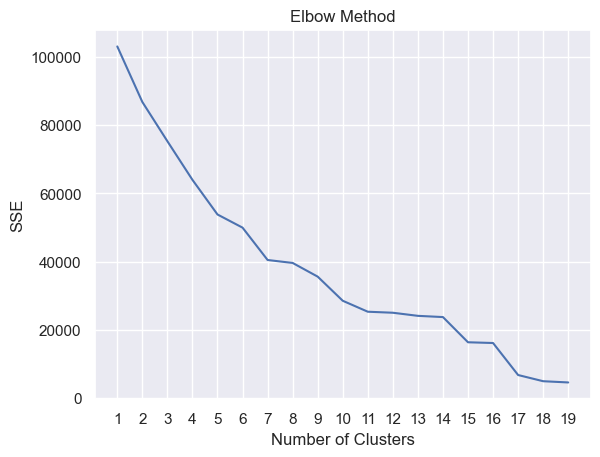

In [75]:
# Visualizing the results for identifying the Optimal K Value
plt.plot(range(1, 20), sse)
plt.xticks(range(1, 20))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()

**Elbow Method is not suitable since we are not achieving at a proper Elbow in order to find the optimal value of 'k'.** 

In [76]:
# Using 'Silhoutte Method' in order to find the optimal value of 'k'
range_n_clusters = range(2, 11)

silhouette_scores = []
 
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(kmeans_standardized)
    silhouette_avg = silhouette_score(kmeans_standardized, cluster_labels)
    silhouette_scores.append(silhouette_avg)

C:\Users\Sufia Shaikh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Sufia Shaikh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Sufia Shaikh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Sufia Shaikh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Sufia Shaikh\anacon

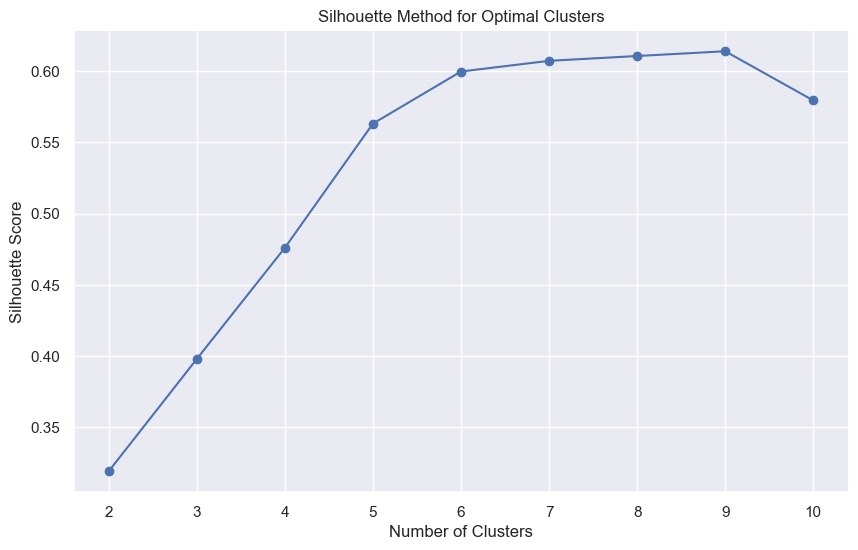

In [77]:
# Plotting the 'Silhouette Scores' for getting the optimal value of 'k'
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [78]:
# Choose the optimal number of clusters based on the silhouette scores
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is {optimal_n_clusters}.")

The optimal number of clusters is 9.


In [79]:
# Apply K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(kmeans_standardized)

# Append cluster assignments to original DataFrame
kmeans_features['k-means clusters'] = cluster_labels
 
# Display the resulting DataFrame with cluster assignments
kmeans_features[['Movie Genre', 'Overall IMDB Rating', 'Number of User Reviews', 'Actors List', 'k-means clusters']]

C:\Users\Sufia Shaikh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Sufia Shaikh\AppData\Local\Temp\ipykernel_2912\1042067925.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmeans_features['k-means clusters'] = cluster_labels


Movie Genre  Overall IMDB Rating  \
0     [Horror, Mystery, Thriller]                  6.0   
1     [Horror, Mystery, Thriller]                  6.0   
2     [Horror, Mystery, Thriller]                  6.0   
3       [Comedy, Drama, Thriller]                  7.0   
4       [Comedy, Drama, Thriller]                  7.0   
...                           ...                  ...   
9366                     [Horror]                  7.3   
9367                     [Horror]                  7.3   
9368                     [Comedy]                  6.0   
9369                     [Comedy]                  6.0   
9370                     [Comedy]                  6.0   

      Number of User Reviews           Actors List  k-means clusters  
0                        357            Tobin Bell                 4  
1                        357         Shawnee Smith                 4  
2                        357   Synnøve Macody Lund                 4  
3                          8         Barry Keoghan                 4  
4                          8          Jacob Elordi                 4  
...                      ...                   ...               ...  
9366                       2         LaVail Duncan                 0  
9367                       2      James L. Edwards                 0  
9368                       2       Adesina Adebayo                 0  
9369                       2       Alakija Adebayo                 0  
9370                       2          Femi Adebayo                 0  

[9371 rows x 5 columns]

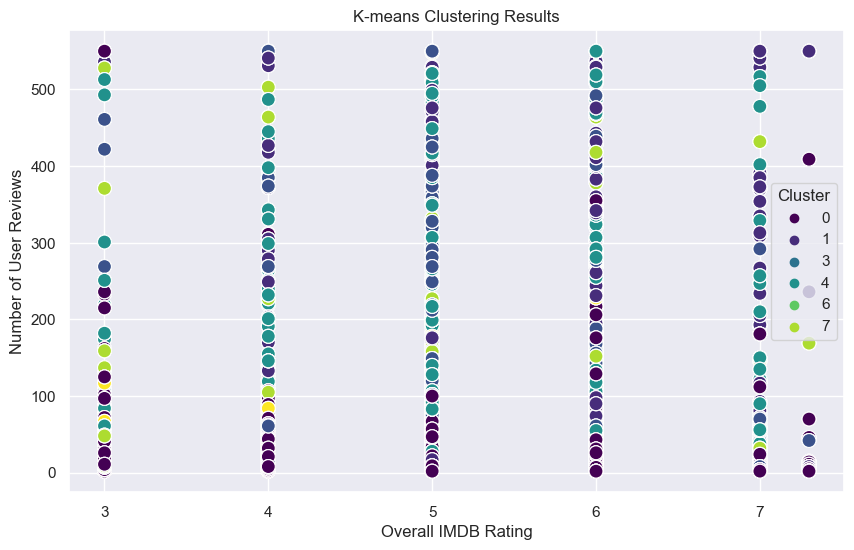

In [80]:
# Visualizing the K-Means results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Overall IMDB Rating', y='Number of User Reviews', hue='k-means clusters', data=kmeans_features, palette='viridis', s=100)
plt.xlabel('Overall IMDB Rating')
plt.ylabel('Number of User Reviews')
plt.title('K-means Clustering Results')
plt.legend(title='Cluster')
plt.show()

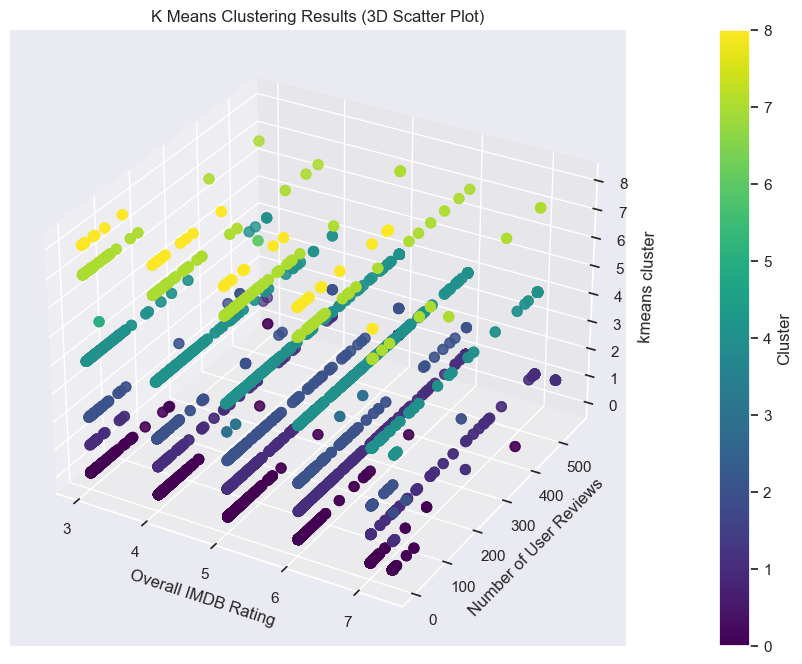

In [81]:
# Visualize the results in 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    kmeans_features['Overall IMDB Rating'],
    kmeans_features['Number of User Reviews'],
    kmeans_features['k-means clusters'],
    c=kmeans_features['k-means clusters'],
    cmap='viridis',
    s=50)

ax.set_xlabel('Overall IMDB Rating')
ax.set_ylabel('Number of User Reviews')
ax.set_zlabel('kmeans cluster')
ax.set_title('K Means Clustering Results (3D Scatter Plot)')
colorbar = fig.colorbar(scatter, ax=ax, pad=0.1)
colorbar.set_label('Cluster')
plt.show()

In [82]:
# Identify the most suitable actors for each genre in the cluster
suitable_actors = []
genre_clusters = []
for i in range(optimal_n_clusters):
    cluster_movies = kmeans_features[kmeans_features['k-means clusters'] == i]
    actor_counts = cluster_movies['Actors List'].explode().value_counts()
    genre_counts = cluster_movies['Movie Genre'].explode().value_counts()
    suitable_actors.append(actor_counts.index[0])
    genre_clusters.append(genre_counts.index[0])
genre_actors_clusters = pd.DataFrame(suitable_actors, columns=['Actors'])
genre_actors_clusters = pd.concat([genre_actors_clusters,pd.DataFrame(genre_clusters, columns=['Genre'])], axis=1)
genre_actors_clusters.insert(0, 'Cluster_KNN', range(optimal_n_clusters))
genre_actors_clusters

Cluster_KNN               Actors      Genre
0            0           Tom Arnold     Horror
1            1            Tom Hanks     Comedy
2            2            Dean Cain     Comedy
3            3          Tyler Perry  Adventure
4            4         Bruce Willis      Drama
5            5           Kj Schrock  Animation
6            6           Iola Evans      Drama
7            7   Natasha Henstridge     Horror
8            8        Frank Woodley     Horror

## 2. Applying Unsupervised Learning Model : Mean Shift

**Advantage:** 
Mean Shift automatically adapts to the data by establishing the bandwidth, making it appropriate for situations with different cluster forms and densities.

**Disadvantage:** 
Mean Shift can be computationally expensive, especially for large datasets, which may limit its applicability in circumstances with limited processing resources.

**Suitability:**
Mean Shift is appropriate for cases in which cluster form and density vary and an adaptive method to estimating cluster bandwidth is sought. It's especially handy when the number of clusters isn't known ahead of time.

In [83]:
meanshift_features = kmeans_features
meanshift_features['Actors List'] = meanshift_features['Actors List'].astype(str)

C:\Users\Sufia Shaikh\AppData\Local\Temp\ipykernel_2912\3786684086.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meanshift_features['Actors List'] = meanshift_features['Actors List'].astype(str)


In [84]:
# One-hot encoding the 'Actors List' feature
actor_encoder = OneHotEncoder(sparse=False)
actor_encoded = pd.DataFrame(actor_encoder.fit_transform(meanshift_features[['Actors List']]), columns=actor_encoder.get_feature_names_out(['Actors List']), index=meanshift_features.index)

C:\Users\Sufia Shaikh\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [89]:
# Selecting the Top-100 Actor's from the 'Actor Encoded Dataframe'

# Sum the occurrences of each actor across all clusters
actor_counts_total = actor_encoded.sum(axis=0)

# Select the top 100 actors based on total count
top_100_actors = actor_counts_total.nlargest(100).index.tolist()

# Filter the original DataFrame to include only the top 100 actors
top_100_actors_df = actor_encoded[top_100_actors]

# Replacing the 'Actors List_' in the column names with "" and removing extra whitespaces
top_100_actors_df.columns=top_100_actors_df.columns.str.replace("Actors List_","").str.strip()

# Display the DataFrame with the top 100 actors
top_100_actors_df.columns

Index(['Bruce Willis', 'Eric Roberts', 'Scott Adkins', 'Tom Sizemore',
       'Bruce Willis', 'Dermot Mulroney', 'Nicolas Cage', 'Dolph Lundgren',
       'Frank Grillo', 'Tom Sizemore', 'Liam Neeson', 'Michael Paré',
       'Tom Arnold', 'Ana de Armas', 'Dean Cain', 'Emily Wyatt',
       'Eric Roberts', 'Graham Greene', 'J.K. Simmons', 'Jenna Ortega',
       'Joel McHale', 'John Cena', 'John Schneider', 'Josh Duhamel',
       'Kaylee Williams', 'Mel Gibson', 'Michael Paré', 'Robert LaSardo',
       'Salma Hayek', 'Emile Hirsch', 'Guy Pearce', 'Jonathan Rhys Meyers',
       'Louis Mandylor', 'Michael Madsen', 'Antonio Banderas',
       'Anya Taylor-Joy', 'Augie Duke', 'Awkwafina', 'Bai Ling',
       'Chris Cimperman', 'Chris Pine', 'Dee Wallace', 'Eiza González',
       'Famke Janssen', 'Gillian Jacobs', 'Ike Amadi', 'James Marsden',
       'Jamie Dornan', 'Jamie Morgan', 'Janel Parrish', 'Jeff Fahey',
       'John Gallagher Jr.', 'John Malkovich', 'Justin Long', 'Lashana Lynch',
      

In [90]:
# Applying 'MultiLabelBinarizer' to encode Genres
mlb_genres = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb_genres.fit_transform(meanshift_features['Movie Genre']), columns=mlb_genres.classes_, index=meanshift_features.index)

In [91]:
# Combine the 'Encoded Actors' and 'Genres' with the rest of the features
meanshift_features_encoded = pd.concat([kmeans_features.drop(['Actors List', 'Movie Genre'], axis=1), top_100_actors_df, genres_encoded], axis=1)

In [92]:
# Checking missing values
meanshift_features_encoded.isna().sum().sum()

0

In [ ]:
# Applying 'Mean Shift' Clustering
meanshift = MeanShift(bandwidth=30)
meanshift_features_encoded['MeanShift_Labels'] = meanshift.fit_predict(meanshift_features_encoded)

In [ ]:
# Finding the number of Clusters Generated
len(meanshift_features_encoded['MeanShift_Labels'].unique())

In [ ]:
# Visualizing the results obtained after Mean Shift Clustering - 2D Visualization
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='Overall IMDB Rating', 
                          y='Number of User Reviews', 
                          hue='MeanShift_Labels',
                          palette='viridis',
                          size='MeanShift_Labels',
                          sizes=(50, 200),
                          data=meanshift_features_encoded)

plt.title('2D Scatter Plot of MeanShift Clustering', fontsize=16)
plt.xlabel('Overall IMDB Rating', fontsize=14)
plt.ylabel('Number of User Reviews', fontsize=14)
scatter.legend(title='MeanShift Labels', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()

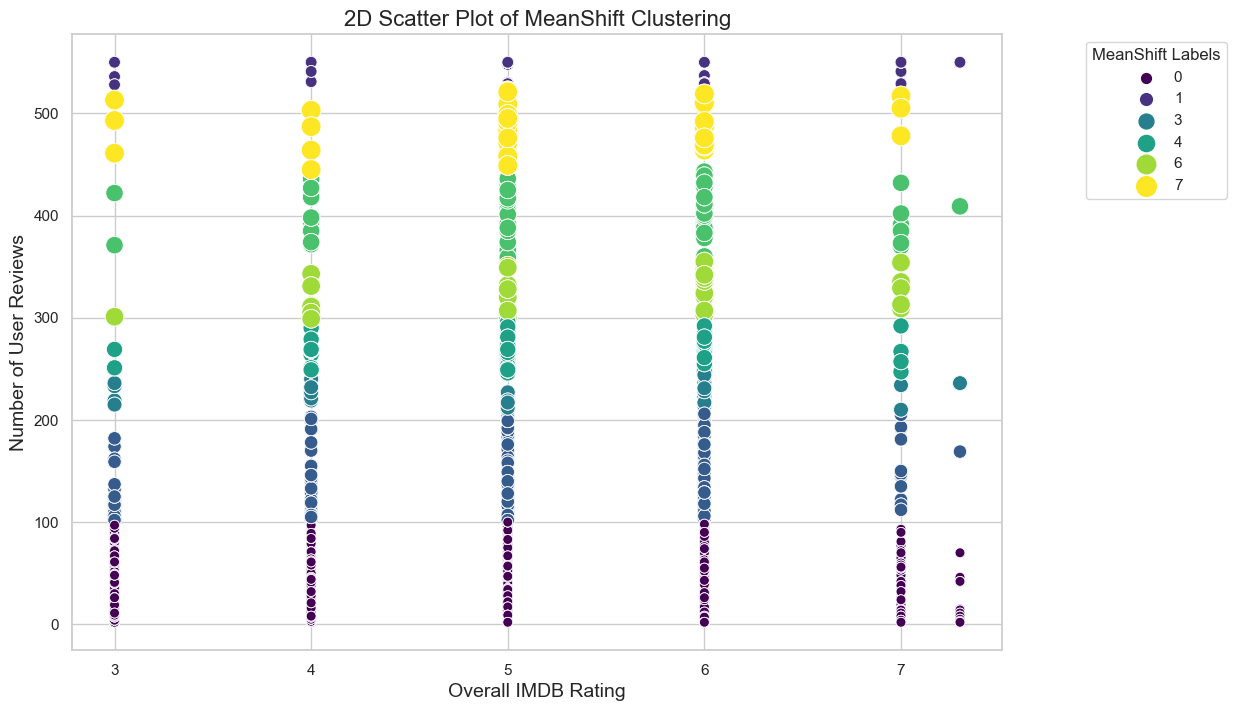

In [ ]:
# Visualizing the results obtained after Mean Shift Clustering - 3D Visualization
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    meanshift_features_encoded['Overall IMDB Rating'],
    meanshift_features_encoded['Number of User Reviews'],
    meanshift_features_encoded['MeanShift_Labels'],
    c=meanshift_features_encoded['MeanShift_Labels'],
    cmap='viridis',
    s=50
)

ax.set_xlabel('Overall IMDB Rating')
ax.set_ylabel('Number of User Reviews')
ax.set_zlabel('Meanshift Clusters')
ax.set_title('Meanshift Clusters Results (3D Scatter Plot)')

colorbar = fig.colorbar(scatter, ax=ax, pad=0.1)
colorbar.set_label('Cluster')

plt.show()

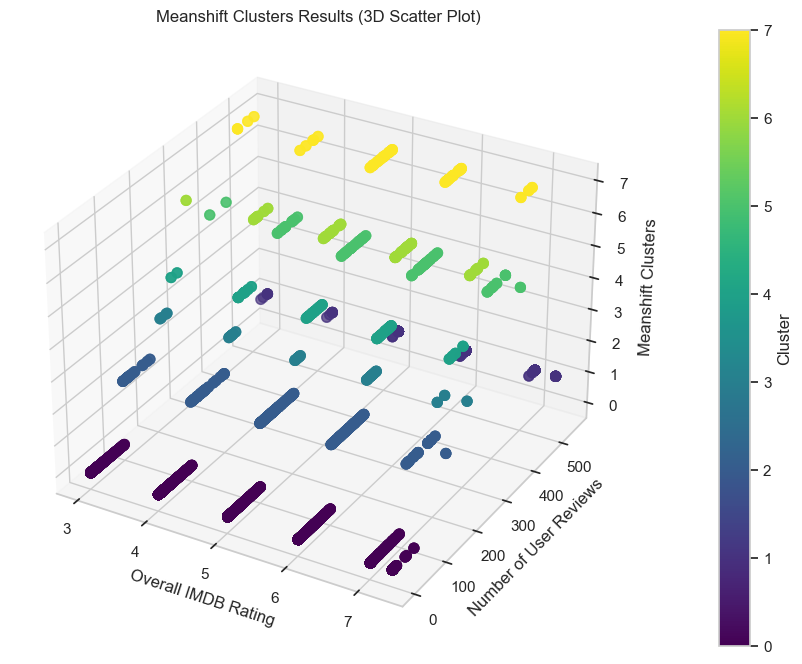

In [ ]:
# Create a mapping of clusters with suitable actors for each genre
suitable_actors_mean_shift = []
genre_clusters_mean_shift = []

for label in meanshift_features_encoded['MeanShift_Labels'].unique():
    cluster_movies = meanshift_features_encoded[meanshift_features_encoded['MeanShift_Labels'] == label]
    
    # Sum the occurrences of each actor across all movies in the cluster
    actor_counts = cluster_movies[top_100_actors_df.columns].sum()
    
    # Get the actor with the highest count
    most_common_actor = actor_counts.idxmax()
    
    # Get the corresponding genre for the cluster
    genre_counts = cluster_movies[genres_encoded.columns].sum().idxmax()
    
    genre_clusters_mean_shift.append(genre_counts)

cluster_results_mean_shift = pd.DataFrame({'Actors': suitable_actors_mean_shift, 'Genre': genre_clusters_mean_shift, 'MeanShift_Labels': meanshift_features_encoded['MeanShift_Labels'].unique()})
cluster_results_mean_shift

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Actors</th>
      <th>Genre</th>
      <th>MeanShift_Labels</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>Gerard Butler</td>
      <td>Drama</td>
      <td>5</td>
    </tr>
    <tr>
      <th>1</th>
      <td>Eric Roberts</td>
      <td>Comedy</td>
      <td>0</td>
    </tr>
    <tr>
      <th>2</th>
      <td>Jamie Dornan</td>
      <td>Comedy</td>
      <td>4</td>
    </tr>
    <tr>
      <th>3</th>
      <td>Anya Taylor-Joy</td>
      <td>Action</td>
      <td>1</td>
    </tr>
    <tr>
      <th>4</th>
      <td>Madison Iseman</td>
      <td>Drama</td>
      <td>2</td>
    </tr>
    <tr>
      <th>5</th>
      <td>Bruce Willis</td>
      <td>Drama</td>
      <td>7</td>
    </tr>
    <tr>
      <th>6</th>
      <td>Nicolas Cage</td>
      <td>Drama</td>
      <td>6</td>
    </tr>
    <tr>
      <th>7</th>
      <td>Bruce Willis</td>
      <td>Comedy</td>
      <td>3</td>
    </tr>
  </tbody>
</table>
</div>

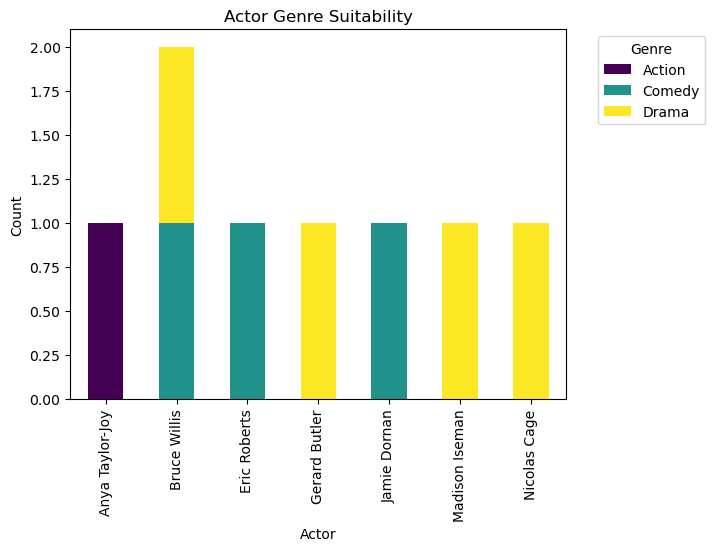

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
data = {
    'Actor': ['Gerard Butler', 'Eric Roberts', 'Jamie Dornan', 'Anya Taylor-Joy', 'Madison Iseman', 'Bruce Willis', 'Nicolas Cage', 'Bruce Willis'],
    'Genre': ['Drama', 'Comedy', 'Comedy', 'Action', 'Drama', 'Drama', 'Drama', 'Comedy']
}
 
df = pd.DataFrame(data)
 
df_count = df.groupby(['Actor', 'Genre']).size().reset_index(name='Count')
 
# Pivot the data for plotting
pivot_df = df_count.pivot(index='Actor', columns='Genre', values='Count').fillna(0)
 
# Plotting the bar chart
ax = pivot_df.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Actor Genre Suitability')
plt.xlabel('Actor')
plt.ylabel('Count')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
 
# Display the plot
plt.show()

## 3. Applying Unsupervised Learning Model : Gaussian Mixture

**Advantage:** 
GMM calculates the probability or likelihood of a data item belonging to each cluster, allowing for a more nuanced view of cluster membership.

**Disadvantage:** 
Because GMM results might be sensitive to initial values, careful initialization is required to avoid convergence to local minima.

**Suitability:**
GMM is appropriate for cases in which clusters have varying shapes, sizes, and orientations. It is especially effective when soft cluster assignment is sought and the underlying data distribution is believed to be a blend of Gaussian distributions.

In [ ]:
GMM_features = df_genre[cols]
scaler = StandardScaler()
GMM_standardized = scaler.fit_transform(GMM_features.drop(columns=['Movie Genre','Actors List']))
# Define a range of components to try
n_components_range = range(1, 11)

In [ ]:
# Fit GMM models with different numbers of components
# Using Bayesian Information Criterion (BIC) -- this is determining the best n values for clustering
bic_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(GMM_standardized)
    bic_scores.append(gmm.bic(GMM_standardized))

In [ ]:
# Plotting the 'BIC Scores' for getting the optimal value of 'k'
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, marker='o')
plt.title('BIC for Optimal Number of Components in GMM')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.show()

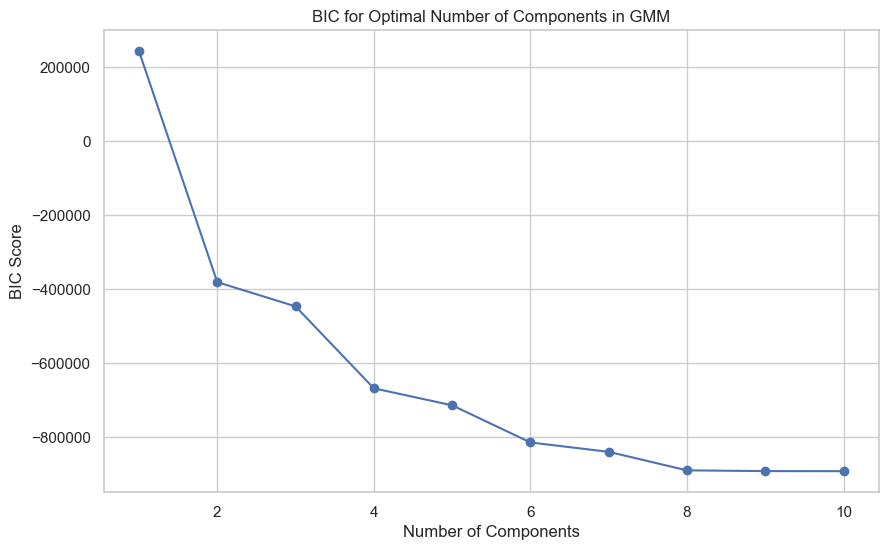

In [ ]:
# Choose the optimal number of clusters based on the BIC scores
optimal_components = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of components: {optimal_components}")

Optimal number of components: 10


In [ ]:
# Apply Gaussian Mixture with the optimal number of clusters
gmm = GaussianMixture(n_components=optimal_components, random_state=42)
GMM_features['Cluster_GMM'] = gmm.fit_predict(GMM_standardized)

In [ ]:
# Visualize the GMM clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Overall IMDB Rating', y='Number of User Reviews', hue='Cluster_GMM', data=GMM_features, palette='viridis', s=50)
plt.xlabel('Overall IMDB Rating')
plt.ylabel('Number of User Reviews')
plt.title('Gaussian Mixture Model Clustering Results')
plt.legend(title='Clusters', loc='upper right')
plt.show()

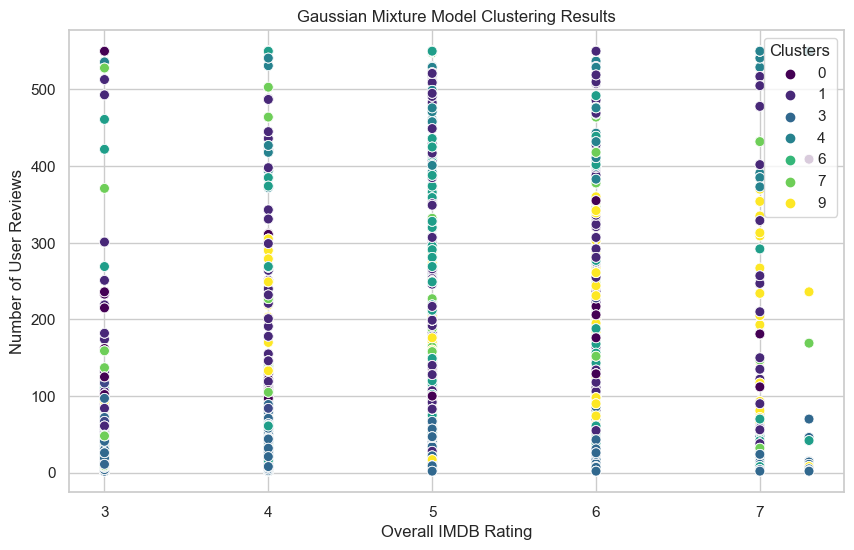

In [ ]:
# Visualize the results in 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    GMM_features['Overall IMDB Rating'],
    GMM_features['Number of User Reviews'],
    GMM_features['Cluster_GMM'],
    c=GMM_features['Cluster_GMM'],
    cmap='viridis',
    s=50
)

ax.set_xlabel('Overall IMDB Rating')
ax.set_ylabel('Number of User Reviews')
ax.set_zlabel('Gaussian Mixture Cluster')
ax.set_title('Gaussian Mixture Clustering Results (3D Scatter Plot)')

colorbar = fig.colorbar(scatter, ax=ax, pad=0.1)
colorbar.set_label('Gaussian Mixture cluster')

plt.show()

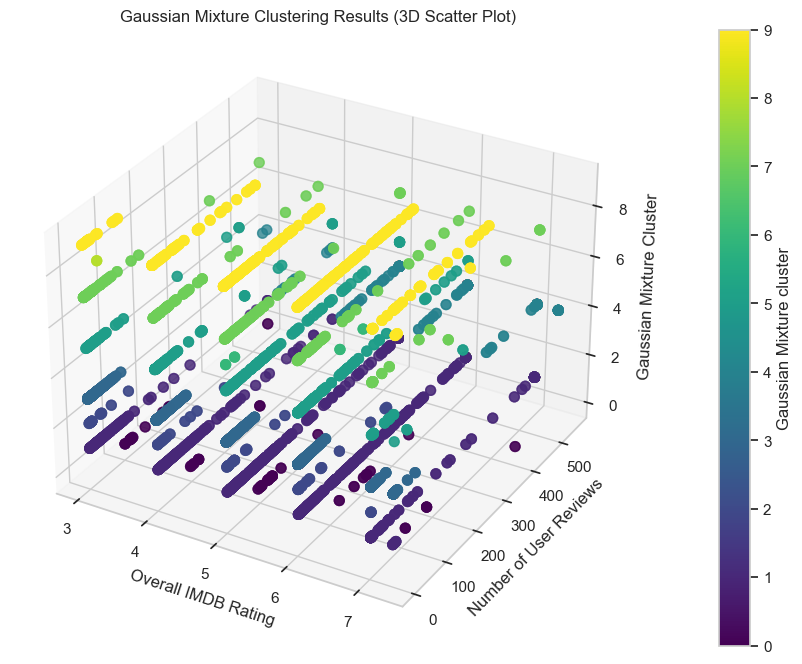

In [ ]:
# Identify the most suitable actors for each genre on the basis of GMM cluster
suitable_actors = []
genre_clusters = []

for i in range(optimal_components):
    cluster_movies = GMM_features[GMM_features['Cluster_GMM'] == i]
    actor_counts = cluster_movies['Actors List'].explode().value_counts()
    genre_counts = cluster_movies['Movie Genre'].explode().value_counts()
    suitable_actors.append(actor_counts.index[0])
    genre_clusters.append(genre_counts.index[0])

# Create a DataFrame with suitable actors and genres for each GMM cluster
genre_actors_clusters_gmm = pd.DataFrame(suitable_actors, columns=['Actors'])
genre_actors_clusters_gmm = pd.concat([genre_actors_clusters_gmm, pd.DataFrame(genre_clusters, columns=['Genre'])], axis=1)
genre_actors_clusters_gmm.insert(0, 'Cluster_GMM', range(optimal_components))
genre_actors_clusters_gmm

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Cluster_GMM</th>
      <th>Actors</th>
      <th>Genre</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0</td>
      <td>Mark Vasconcellos</td>
      <td>Horror</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1</td>
      <td>Bruce Willis</td>
      <td>Drama</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2</td>
      <td>Frank Woodley</td>
      <td>Horror</td>
    </tr>
    <tr>
      <th>3</th>
      <td>3</td>
      <td>Tom Arnold</td>
      <td>Horror</td>
    </tr>
    <tr>
      <th>4</th>
      <td>4</td>
      <td>Chris Pratt</td>
      <td>Adventure</td>
    </tr>
    <tr>
      <th>5</th>
      <td>5</td>
      <td>Dean Cain</td>
      <td>Comedy</td>
    </tr>
    <tr>
      <th>6</th>
      <td>6</td>
      <td>Tyler Perry</td>
      <td>Adventure</td>
    </tr>
    <tr>
      <th>7</th>
      <td>7</td>
      <td>Natasha Henstridge</td>
      <td>Horror</td>
    </tr>
    <tr>
      <th>8</th>
      <td>8</td>
      <td>Kj Schrock</td>
      <td>Animation</td>
    </tr>
    <tr>
      <th>9</th>
      <td>9</td>
      <td>James Marsden</td>
      <td>Comedy</td>
    </tr>
  </tbody>
</table>
</div>

In [ ]:
# Merging all the 3 Unsupervised Learning results and grouping the results on the basis of 'Actors' and checking the count of individual
df_final=pd.concat([cluster_results_mean_shift,genre_actors_clusters_gmm,genre_actors_clusters],axis=0).groupby('Actors').count()
df_final

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Genre</th>
      <th>MeanShift_Labels</th>
      <th>Cluster_GMM</th>
      <th>Cluster_KNN</th>
    </tr>
    <tr>
      <th>Actors</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Bruce Willis</th>
      <td>2</td>
      <td>0</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>Dean Cain</th>
      <td>2</td>
      <td>0</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>Frank Woodley</th>
      <td>2</td>
      <td>0</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>James Marsden</th>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <th>Natasha Henstridge</th>
      <td>2</td>
      <td>0</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>Anya Taylor-Joy</th>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>Bruce Willis</th>
      <td>2</td>
      <td>2</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>Chris Pratt</th>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <th>Eric Roberts</th>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>Gerard Butler</th>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>Iola Evans</th>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
    </tr>
    <tr>
      <th>Jamie Dornan</th>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>Kj Schrock</th>
      <td>2</td>
      <td>0</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>Madison Iseman</th>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>Mark Vasconcellos</th>
      <td>1</td>
      <td>0</td>
      <td>1</td>
      <td>0</td>
    </tr>
    <tr>
      <th>Nicolas Cage</th>
      <td>1</td>
      <td>1</td>
      <td>0</td>
      <td>0</td>
    </tr>
    <tr>
      <th>Tom Arnold</th>
      <td>2</td>
      <td>0</td>
      <td>1</td>
      <td>1</td>
    </tr>
    <tr>
      <th>Tom Hanks</th>
      <td>1</td>
      <td>0</td>
      <td>0</td>
      <td>1</td>
    </tr>
    <tr>
      <th>Tyler Perry</th>
      <td>2</td>
      <td>0</td>
      <td>1</td>
      <td>1</td>
    </tr>
  </tbody>
</table>
</div>

# Thank you